In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy
import dataclasses

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp
import pprint

from fusiondls.geometry import *
from fusiondls.SOLPSreader import read_balance

from fusiondls import MagneticGeometry, SimulationInputs, run_dls, file_read, file_write
from fusiondls.analytic_cooling_curves import LfuncKallenbach

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *
from code_comparison.solps_pp import *
from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline
%load_ext autoreload
%autoreload 2


# Read SOLPS case

In [2]:
balance_paths = {
    "100MW_inner_arpuff" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed\step0_A5e21D1e24spr",
    "100MW_innerar_midplanepuff" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed_impomp_puff\step2_Xomp20_A8e21D0p4e24sp50r",
}

store_slc = {}

for case in balance_paths:
    print(case)
    if "balance.nc" in os.listdir(balance_paths[case]):
        store_slc[case] = SOLPScase(balance_paths[case])
        store_slc[case].get_species()
        store_slc[case].get_impurity_stats("Ar", all_states = True)
    else:
        print(f"Skipping {case} as no balance.nc file found")
        
case = "100MW_innerar_midplanepuff"
sepadd_select = dict(outer_lower = 2, inner_lower = 1)

100MW_inner_arpuff
Saving all states
Added total radiation, density and fraction for Ar
100MW_innerar_midplanepuff
Saving all states
Added total radiation, density and fraction for Ar


# Common formatting stuff

In [3]:
labels = {'100MW_inner_arpuff' : "PFR puff", '100MW_innerar_midplanepuff' : "Midplane puff"}

# Prepare DLS geometry from SOLPS
- eqb is the usual high res interpolated version
- eqb_alt uses SOLPS data explicitly for an identical comparison

In [4]:
def translate_side(x):
    return x.split("_")[0][0] + x.split("_")[1][0]

translate_side("inner_lower")

'il'

In [5]:
eqb = dict()       # Geometry calculated using DLS built-in routines
eqb_alt = dict()   # Geometry calculated with my SOLPS post-processing routines

for case in balance_paths:
    print(case)
    eqb[case] = dict()
    eqb_alt[case] = dict()
    for region in ["outer_lower", "inner_lower", "outer_upper", "inner_upper"]:
        eqb[case][region] = dict()
        eqb_alt[case][region] = dict()
        for i in range(10):
            eqb[case][region][i] = read_balance(
                File = os.path.join(balance_paths[case], "balance.nc"), Type = region.split("_")[0][0] + region.split("_")[1][0], sepadd=i, 
                resolution = 500, diagnostic_plot = False)
            
            
            df = store_slc[case].get_1d_poloidal_data(["R", "Z", "Btot", "Bpol"], 
                                                      region = region, sepadd = i,
                                                      target_first = True).reset_index(drop = True)
            
            params = {}
            
            for key in ["R", "Z", "Btot", "Bpol", "Spol", "Spar"]:
                params[key] = np.array(df[key].values)
                
            params["Xpoint"] = df[df["Xpoint"]==1].index[0]

            geom = MagneticGeometry(params["Bpol"], params["Btot"], params["R"], params["Z"], params["Spar"], params["Spol"], params["Xpoint"])

            
            eqb_alt[case][region][i] = geom
            
            # eqb_alt[case][region][i] = Profile(params["R"], params["Z"], df[df["Xpoint"]==1].index[0], params["Btot"], params["Bpol"], params["Spar"], params["Spol"], name = "outer_lower_sepadd1")
    

100MW_inner_arpuff
100MW_innerar_midplanepuff


# Prepare cooling curves

In [6]:
curves = {}
T = np.linspace(0, 1000, 1000)

## radas

In [7]:
rd = dict(
    Ar = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc"),
    Ne = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\neon.nc"),
    N = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\nitrogen.nc")    
)

for species in rd.keys():
    curves[species] = {}
    ds = rd[species]

    for netau in ds.coords["dim_ne_tau"].values:
        rate = ds["equilibrium_Lz"].sel(dim_ne_tau = netau, dim_electron_density=1e20, method="nearest")
        netau_name = netau
        curves[species][netau_name*1e3] = sp.interpolate.interp1d(
            ds.coords["dim_electron_temp"].values, rate.values, kind = "cubic",
            fill_value = (rate.values[0], rate.values[-1]), bounds_error = False
            )


## SOLPS

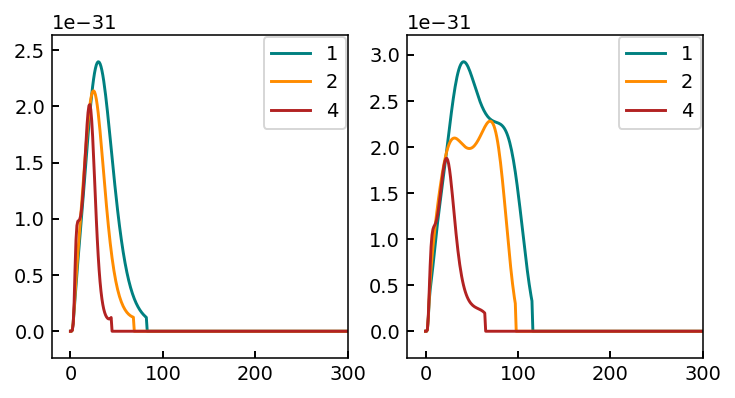

In [8]:
curves["extracted_outer"] = {}
curves["extracted_inner"] = {}

for i in range(8):
    curves["extracted_outer"][i] = store_slc[case].extract_cooling_curve("Ar", "outer_lower", sepadd = i, order = 10)
    curves["extracted_inner"][i] = store_slc[case].extract_cooling_curve("Ar", "inner_lower", sepadd = i, order = 8)
    
    
fig, axes = plt.subplots(1,2, figsize = (6,3))

for i in [1,2,4]:

    axes[0].plot(T, [curves["extracted_inner"][i](temp) for temp in T], label = i)
    axes[1].plot(T, [curves["extracted_outer"][i](temp) for temp in T], label = i)
    
for ax in axes:
    ax.legend()
    ax.set_xlim(-20, 300)


## Custom

In [9]:
def LfuncArParametricTriShoulder(T, x1 = 0, x2 = 60, height = 0.5):
    """
    Analytical approximation of the Ar cooling curve
    Tmax is the temperature at which the radiation goes to zero on the hot end
    
    """
    
    # Maximum from actual Ar curve
    max = 1.7210363586464083e-31
    
    x0 = 0
    y0 = 0
    # x1 = max_pos
    y1 = max
    # x2 = 
    y2 = max * height
    

    if T < x1:
        Lz = (y0 * (x1 - T) + y1 * (T - x0)) / (x1 - x0)
    elif T >= x1 and T < x2:
        Lz = (y1 * (x2 - T) + y2 * (T - x1)) / (x2 - x1)
    else:
        Lz = y2

    
    return Lz

## Compare curves

### Outer

C:\Users\mikek\AppData\Local\Temp\ipykernel_55580\2267227371.py:42: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(-10,1000)


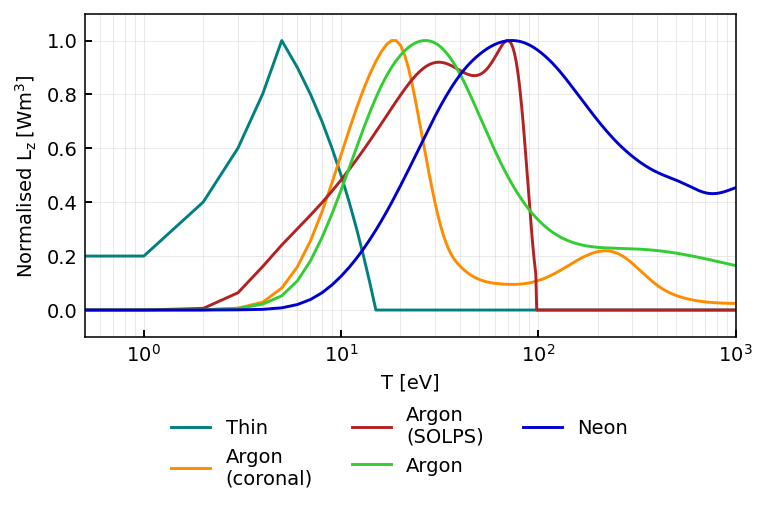

In [10]:
netau = 1e19

# curves_labels = {
#     "Thin" : "Thin",
#     "Nitrogen" : "Nitrogen (coronal)",
#     "Argon\n(coronal)" : curves["Ar"][1e21],
#     "Argon" : curves["Ar"][netau],
#     "Nitrogen" : curves["N"][netau],
#     "Neon" : curves["Ne"][netau],
#     "SOLPS" : curves["extracted_inner"][sepadd_select["inner_lower"]],    
# }

curves["set_outer"] = {
    "Thin" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    "Argon\n(coronal)" : curves["Ar"][1e21],
    "Argon\n(SOLPS)" : curves["extracted_outer"][sepadd_select["outer_lower"]],    
    r"Argon" : curves["Ar"][netau],
    r"Neon" : curves["Ne"][netau],
    
    
    # "Curve 1" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    # "Curve 2" : curves["Ar"][1e16*1e3],
    # "Curve 3" : curves["Ar"][1e14*1e3],
    # "SOLPS" : curves["extracted_outer"][sepadd_select["outer_lower"]],
}
    
fig, ax = plt.subplots(figsize = (6,3))


for name, function in curves["set_outer"].items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 3, frameon = False)

ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))

ax.set_xscale("log")
ax.set_xlim(-10,1000)

# ax.set_yscale("log")
# ax.set_ylim(1e-3, 1)

ax.grid(which = "both", visible = True)
# fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_curves_outer.pdf", format = "pdf")

### Inner

(-10.0, 200.0)

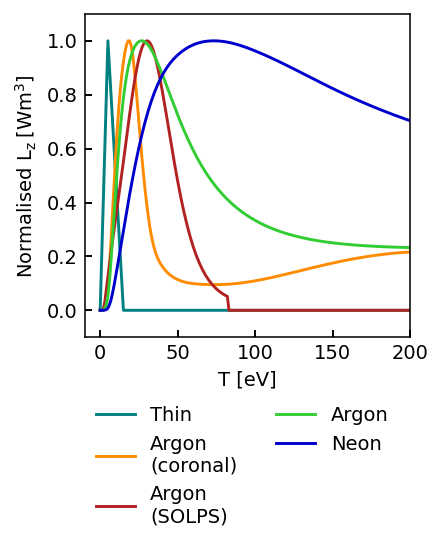

In [11]:
curves["set_inner"] = {
    
    "Thin" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    "Argon\n(coronal)" : curves["Ar"][1e21],
    "Argon\n(SOLPS)" : curves["extracted_inner"][sepadd_select["inner_lower"]],   
    "Argon" : curves["Ar"][netau],
    # "Nitrogen 1e19" : curves["N"][netau],
    "Neon" : curves["Ne"][netau],
     
} 
fig, ax = plt.subplots(figsize = (3,3))


for name, function in curves["set_inner"].items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 2, frameon = False)
ax.set_xlim(-10,200)
# fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_curves_inner.pdf", format = "pdf")

# Outer profiles

In [12]:
store_profiles = {}
store_profiles["outer"] = {}
store_profiles["inner"] = {}

## f_R

In [13]:
p = eqb[case]["outer_lower"][sepadd_select["outer_lower"]]
base_profile = copy.deepcopy(p)
# base_profile = Profile(p["R"], p["Z"], p["Xpoint"], p["Btot"], p["Bpol"], p["S"], p["Spol"], name = "base")

Text(0.5, 1.0, 'Flux expansion profiles')

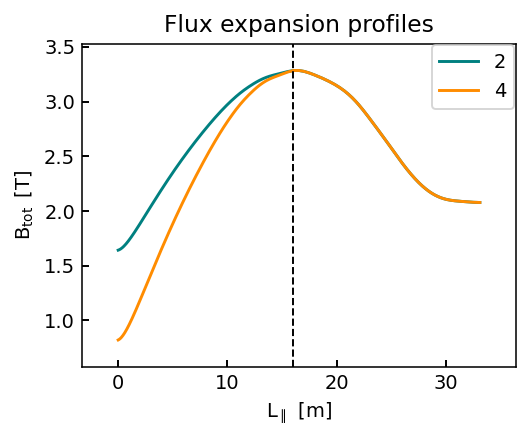

In [14]:
list_fR = [2, 4]
store_profiles["outer"]["fR"] = {}

fig, ax = plt.subplots(figsize = (4,3))

for fR in list_fR:
    store_profiles["outer"]["fR"][fR] = base_profile.scale_flux_expansion(expansion = fR)
    
    ax.plot(store_profiles["outer"]["fR"][fR]["Spar"], store_profiles["outer"]["fR"][fR]["Btot"], label = fR)
    
ylims = ax.get_ylim()
ax.vlines(base_profile["Spar"][base_profile["Xpoint"]], *ylims, color = "k", lw = 1.0, linestyle = "--")
ax.set_ylim(ylims)
ax.legend()
ax.set_xlabel(r"$L_{\parallel}\ \ [m]$")
ax.set_ylabel(r"$B_{tot}\ \ [T]$")
ax.set_title("Flux expansion profiles")

## Lc

Text(0.5, 1.0, 'Connection length profiles')

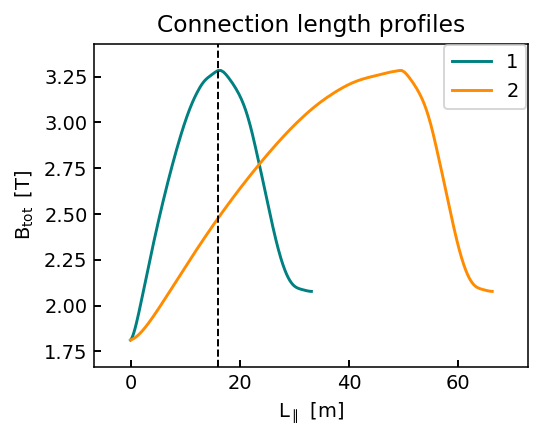

In [15]:
list_Lc_factors = [1, 2]
store_profiles["outer"]["Lc"] = {}

fig, ax = plt.subplots(figsize = (4,3))

for Lc_factor in list_Lc_factors:
    store_profiles["outer"]["Lc"][Lc_factor] = base_profile.scale_connection_length(scale_factor = Lc_factor)
    
    ax.plot(store_profiles["outer"]["Lc"][Lc_factor]["Spar"], store_profiles["outer"]["Lc"][Lc_factor]["Btot"], label = Lc_factor)
    
ylims = ax.get_ylim()
ax.vlines(base_profile["Spar"][base_profile["Xpoint"]], *ylims, color = "k", lw = 1.0, linestyle = "--")
ax.set_ylim(ylims)
ax.legend()
ax.set_xlabel(r"$L_{\parallel}\ \ [m]$")
ax.set_ylabel(r"$B_{tot}\ \ [T]$")
ax.set_title("Connection length profiles")

## Paper profile plot

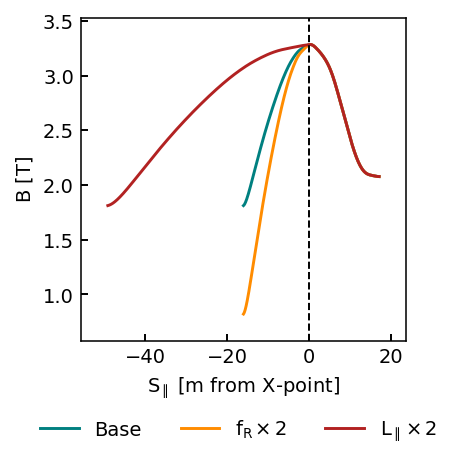

In [16]:
fig, ax = plt.subplots(figsize = (3,3))

profiles = dict(
    base = base_profile,
    fR = store_profiles["outer"]["fR"][4],
    Lc = store_profiles["outer"]["Lc"][2]
)

Sx = profiles["base"]["Spar"][profiles["base"]["Xpoint"]]

ax.plot(profiles["base"]["Spar"] - profiles["base"]["Spar"][profiles["base"]["Xpoint"]], profiles["base"]["Btot"], label = "Base")
ax.plot(profiles["fR"]["Spar"] - profiles["fR"]["Spar"][profiles["fR"]["Xpoint"]], profiles["fR"]["Btot"], label = r"$f_{R} \times 2$")
ax.plot(profiles["Lc"]["Spar"] - profiles["Lc"]["Spar"][profiles["Lc"]["Xpoint"]],  profiles["Lc"]["Btot"], label = r"$L_{\parallel} \times 2$")

ax.set_xlabel(r"$S_{\parallel}$ [m from X-point]")
ax.set_ylabel(r"$B$ [T]")

ylims = ax.get_ylim()
ax.vlines(0, *ylims, color = "k", lw = 1.0, linestyle = "--")
ax.set_ylim(ylims)
fig.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.05), ncols = 3, frameon = False)

# fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_profiles_outer.pdf", format = "pdf")

# Inner profiles

## f_R

In [17]:
p = eqb[case]["inner_lower"][sepadd_select["inner_lower"]]
base_profile = copy.deepcopy(p)

Text(0.5, 1.0, 'Flux expansion profiles')

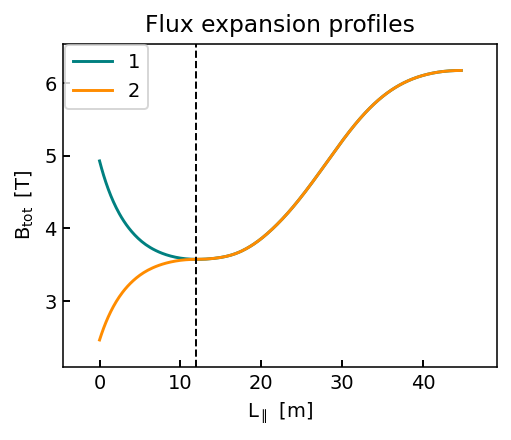

In [18]:
list_fR_factors = [1,2]
store_profiles["inner"]["fR"] = {}

fig, ax = plt.subplots(figsize = (4,3))

for fR in list_fR_factors:
    store_profiles["inner"]["fR"][fR] = base_profile.scale_flux_expansion(scale_factor = fR)
    
    ax.plot(store_profiles["inner"]["fR"][fR]["Spar"], store_profiles["inner"]["fR"][fR]["Btot"], label = fR)
    
ylims = ax.get_ylim()
ax.vlines(base_profile["Spar"][base_profile["Xpoint"]], *ylims, color = "k", lw = 1.0, linestyle = "--")
ax.set_ylim(ylims)
ax.legend()
ax.set_xlabel(r"$L_{\parallel}\ \ [m]$")
ax.set_ylabel(r"$B_{tot}\ \ [T]$")
ax.set_title("Flux expansion profiles")

## Lc

Text(0.5, 1.0, 'Flux expansion profiles')

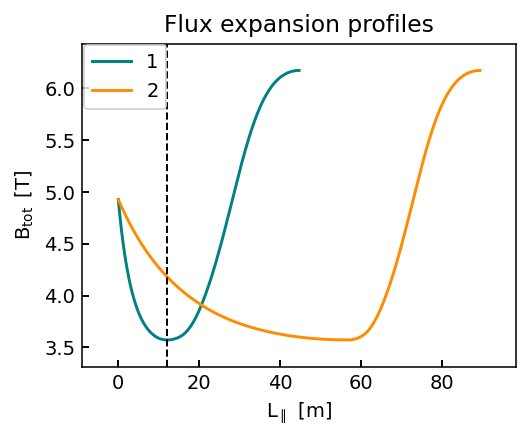

In [19]:
# list_Lc_factors = [1, 1.5]
list_Lc_factors = [1, 2]
store_profiles["inner"]["Lc"] = {}

fig, ax = plt.subplots(figsize = (4,3))

for Lc_factor in list_Lc_factors:
    store_profiles["inner"]["Lc"][Lc_factor] = base_profile.scale_connection_length(scale_factor = Lc_factor)
    
    ax.plot(store_profiles["inner"]["Lc"][Lc_factor]["Spar"], store_profiles["inner"]["Lc"][Lc_factor]["Btot"], label = Lc_factor)
    
ylims = ax.get_ylim()
ax.vlines(base_profile["Spar"][base_profile["Xpoint"]], *ylims, color = "k", lw = 1.0, linestyle = "--")
ax.set_ylim(ylims)
ax.legend()
ax.set_xlabel(r"$L_{\parallel}\ \ [m]$")
ax.set_ylabel(r"$B_{tot}\ \ [T]$")
ax.set_title("Flux expansion profiles")

## Paper profile plot

(2.0921230893663756, 6.541171138719662)

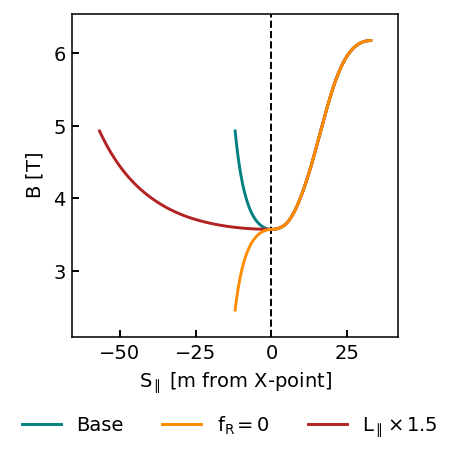

In [20]:
fig, ax = plt.subplots(figsize = (3,3))

profiles = dict(
    base = base_profile,
    fR = store_profiles["inner"]["fR"][list_fR_factors[-1]],
    Lc = store_profiles["inner"]["Lc"][list_Lc_factors[-1]]
)

Sx = profiles["base"]["Spar"][profiles["base"]["Xpoint"]]

ax.plot(profiles["base"]["Spar"] - profiles["base"]["Spar"][profiles["base"]["Xpoint"]], profiles["base"]["Btot"], label = "Base")
ax.plot(profiles["fR"]["Spar"] - profiles["fR"]["Spar"][profiles["fR"]["Xpoint"]], profiles["fR"]["Btot"], label = r"$f_{R} = 0$", zorder = 50)
ax.plot(profiles["Lc"]["Spar"] - profiles["Lc"]["Spar"][profiles["Lc"]["Xpoint"]],  profiles["Lc"]["Btot"], label = r"$L_{\parallel} \times 1.5$")

ax.set_xlabel(r"$S_{\parallel}$ [m from X-point]")
ax.set_ylabel(r"$B$ [T]")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.05), ncols = 3, frameon = False)

ylims = ax.get_ylim()
ax.vlines(0, *ylims, color = "k", lw = 1.0, linestyle = "--")
ax.set_ylim(ylims)
# fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_profiles_inner.pdf", format = "pdf")

# DLS run definition

In [21]:
def run_DLS(custom_inputs, profile, Spar, slc, cvar, region, sepadd, hflux_corr=1):
    ## Get SOLPS field line and max qpar
    df = slc.get_1d_poloidal_data(
        params=["fhx_total", "Ne"], sepadd=sepadd, region=region, target_first=True
    )
    qpar_max = (df["fhx_total"] / df["apar"]).abs().max()
    
    if Spar == "auto":
        SparRange=[
            slc.extract_front_pos(
                sepadd=sepadd,
                region=region,
                impurity="Ar",
                method="qpar_tot",
                threshold=0.05,
            )
        ]
    else:
        SparRange = Spar
        
        

    ## Input deck
    inputs = SimulationInputs(
        control_variable=cvar,
        SparRange = SparRange,
        qpllu0=qpar_max * hflux_corr,
        nu0=df["Ne"].iloc[-1],
        cz0=0.05,
        cooling_curve=slc.extract_cooling_curve("Ar", region, sepadd=sepadd, plot=False),
        kappa0=slc.extract_kappa0(sepadd=sepadd, region=region),
        grid_refinement_ratio=5,
        grid_refinement_width=2,
        grid_resolution=10000,
    )

    try:
        out = run_dls(
            dataclasses.replace(inputs, **custom_inputs),
            profile,
        )
    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)

    return out, compare_SOLPS_DLS(slc, out, cvar, impurity = "Ar", region = region, sepadd = sepadd)

def get_correction_factors(comp):
    fhx_solps = comp.solps[comp.solps["Xpoint"] == 1]["fhx_total"].abs().values[0]
    fhx_dls = comp.dls[comp.dls["Xpoint"] == 1]["qpar"].values[0]
    hflux_factor = fhx_solps / fhx_dls

    kappa_factor = (comp.dls["Te"].max() / comp.solps["Te"].max()) ** 2

    return hflux_factor, kappa_factor

comps_outer = {}
store_outer = {}
comps_inner = {}
store_inner = {}

In [22]:
region = "outer_lower"
slc = store_slc[case]

# Run outer

## Flux expansion

In [23]:
study = "base"
region = "outer_lower"
study = "fR"
comps_outer[study] = {}
store_outer[study] = {}

for curve in curves["set_outer"].keys():
    
    print(f"Solving curve {curve} ------")
    
    comps_outer[study][curve] = {}
    store_outer[study][curve] = {}
    
    input = dict(
        cooling_curve = curves["set_outer"][curve],
        kappa0 = 2500 * 1.28)

    for i in store_profiles["outer"][study].keys():
        print(f"Solving fR {i} ------")
        out, comp = run_DLS(input, store_profiles["outer"]["fR"][i], [0], store_slc[case],  
                            "density", region, sepadd_select[region], hflux_corr = 1.14)  
        comps_outer[study][curve][i] = comp
        store_outer[study][curve][i] = out
    
# comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

Solving curve Thin ------
Solving fR 2 ------
Solving fR 4 ------
Solving curve Argon
(coronal) ------
Solving fR 2 ------
Solving fR 4 ------
Solving curve Argon
(SOLPS) ------
Solving fR 2 ------
Solving fR 4 ------
Solving curve Argon ------
Solving fR 2 ------
Solving fR 4 ------
Solving curve Neon ------
Solving fR 2 ------
Solving fR 4 ------


## Connection length

In [24]:
study = "base"
region = "outer_lower"
study = "Lc"
comps_outer[study] = {}
store_outer[study] = {}

for curve in curves["set_outer"].keys():
    
    print(f"Solving curve {curve} ------")
    
    comps_outer[study][curve] = {}
    store_outer[study][curve] = {}
    
    input = dict(
        cooling_curve = curves["set_outer"][curve],
        kappa0 = 2500 * 1.28)

    for i in store_profiles["outer"][study].keys():
        print(f"Solving {study} {i} ------")
        out, comp = run_DLS(input, store_profiles["outer"][study][i], [0], store_slc[case],  
                            "density", region, sepadd_select[region], hflux_corr = 1.14)  
        comps_outer[study][curve][i] = comp
        store_outer[study][curve][i] = out
    
# comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

Solving curve Thin ------
Solving Lc 1 ------
Solving Lc 2 ------
Solving curve Argon
(coronal) ------
Solving Lc 1 ------
Solving Lc 2 ------
Solving curve Argon
(SOLPS) ------
Solving Lc 1 ------
Solving Lc 2 ------
Solving curve Argon ------
Solving Lc 1 ------
Solving Lc 2 ------
Solving curve Neon ------
Solving Lc 1 ------
Solving Lc 2 ------


# Run inner

## Flux expansion

In [25]:
study = "base"
region = "inner_lower"
study = "fR"
comps_inner[study] = {}
store_inner[study] = {}

for curve in curves["set_inner"].keys():
    
    print(f"Solving curve {curve} ------")
    
    comps_inner[study][curve] = {}
    store_inner[study][curve] = {}
    
    input = dict(
        cooling_curve = curves["set_inner"][curve],
        kappa0 = 2500 * 1.9,
        )

    for i in store_profiles["inner"][study].keys():
        print(f"Solving fR {i} ------")
        
        out, comp = run_DLS(input, store_profiles["inner"][study][i], [0], store_slc[case], 
                            "density", region, sepadd_select[region], hflux_corr = 0.98)  
        comps_inner[study][curve][i] = comp
        store_inner[study][curve][i] = out
    
# comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

Solving curve Thin ------
Solving fR 1 ------
Solving fR 2 ------
Solving curve Argon
(coronal) ------
Solving fR 1 ------
Solving fR 2 ------
Solving curve Argon
(SOLPS) ------
Solving fR 1 ------
Solving fR 2 ------
Solving curve Argon ------
Solving fR 1 ------
Solving fR 2 ------
Solving curve Neon ------
Solving fR 1 ------
Solving fR 2 ------


## Connection length

In [26]:
study = "base"
region = "inner_lower"
study = "Lc"
comps_inner[study] = {}
store_inner[study] = {}

for curve in curves["set_inner"].keys():
    
    print(f"Solving curve {curve} ------")
    
    comps_inner[study][curve] = {}
    store_inner[study][curve] = {}
    
    input = dict(
        cooling_curve = curves["set_inner"][curve],
        kappa0 = 2500 * 1.9,
        )

    for i in store_profiles["inner"][study].keys():
        print(f"Solving {study} {i} ------")
        out, comp = run_DLS(input, store_profiles["inner"][study][i], [0], store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 0.98)  
        comps_inner[study][curve][i] = comp
        store_inner[study][curve][i] = out
    
# comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

Solving curve Thin ------
Solving Lc 1 ------
Solving Lc 2 ------
Solving curve Argon
(coronal) ------
Solving Lc 1 ------
Solving Lc 2 ------
Solving curve Argon
(SOLPS) ------
Solving Lc 1 ------
Solving Lc 2 ------
Solving curve Argon ------
Solving Lc 1 ------
Solving Lc 2 ------
Solving curve Neon ------
Solving Lc 1 ------
Solving Lc 2 ------


# Scalings breakdown - outer

## Prepare data

In [27]:
# param = "Lc"
# study_name = "Lc"

param = "BxBt"
study_name = "fR"
side = "outer"

store_choices = dict(inner = store_inner, outer = store_outer)
comps_choices = dict(inner = comps_inner, outer = comps_outer)


allchecks = {}
allterms = {}
allsc = {}
all_plotweights = {}

analytical = pd.DataFrame()

params = ["Lc", "BxBt"]
studies = ["Lc", "fR"]
# studies = ["Lc"]

for i, study in enumerate(studies):
    param = params[i]
    plot_weights = pd.DataFrame()

    for curve_name in curves[f"set_{side}"].keys():

        store = store_choices[side][study][curve_name]
        names = list(store.keys())

        sc = scaling_comparison(store[names[0]], store[names[-1]], param)
        allsc[curve_name] = sc
        allterms[curve_name] = sc.terms.copy()
        allchecks[curve_name] = sc.terms_check.copy()
        plot_weights[curve_name] = sc.terms["weights"]
        
        
    all_plotweights[study] = plot_weights
        
    ## Calculate analytical results for just Lpar/fR and for full analytical DLS with upstream and avgB ratio
    ratio = sc.terms_full["ratio"]
    param_ratio = ratio[param]
    simple = ratio["BxBt"] * ratio["Lc"]**(2/7)
    simple_avgB = ratio["BxBt"] * ratio["Lc"]**(2/7) * ratio["avgB_ratio"]**(-2/7)
    full = ratio["BxBt"] * ratio["Lc"]**(2/7) * ratio["avgB_ratio"]**(-2/7) * ratio["W_Tu_simple"]**(-1)
    
    
    analytical.loc["simple", study] = np.log(simple) / np.log(param_ratio)
    analytical.loc["simple_avgB", study] = np.log(simple_avgB) / np.log(param_ratio)
    analytical.loc["full", study] = np.log(full) / np.log(param_ratio)
        
analytical
    
    
all_plotweights_outer = all_plotweights
        

In [28]:
study_name = "Lc"
store = store_choices["outer"][study_name]["Neon"]
names = list(store.keys())
out1 = store[names[0]]
out2 = store[names[-1]]

df1 = pd.DataFrame([FrontLocation(out1).stats])
df2 = pd.DataFrame([FrontLocation(out2).stats])

if study_name == "fR": key = "BxBt"
if study_name == "Lc": key = "Lc"
param_ratio = (df2[key] / df1[key]).squeeze()
terms = pd.concat([df1, df2], axis = 0)
terms.index = ["base", "test"]
terms = terms.T

terms_check = pd.DataFrame()
terms_check.loc["total", "cvar_ratio"] = (terms.loc['cvar', 'test'] / terms.loc['cvar', 'base'])**(-1)

terms["ratio"] = (terms["test"] / terms["base"])**(-1)   # Remember that K is positive for lower threshold
terms_full = terms.copy()
terms = terms.loc[["Beff", "W_Tu", "curveclip", "upstream_rad"],:]
terms["log10(ratio)"] = np.log10(terms["ratio"])
terms["abs(log10(ratio))"] = terms["log10(ratio)"].abs()
terms["fraction"] = terms["log10(ratio)"] / terms["abs(log10(ratio))"].sum()

K = np.log(terms["ratio"].product()) / np.log(param_ratio)
terms["weights"] = terms["fraction"] * K / terms[terms>0]["fraction"].sum()  

terms_check.loc["total", "scaling_ratio"] = terms["ratio"].product(axis=0)
terms_check.loc["total", "abs(fraction)"] = terms["fraction"].abs().sum(axis=0)
terms_check.loc["total", "weights"] = terms["weights"].sum(axis=0)
terms_check.loc["total", "abs(weights)"] = terms["weights"].abs().sum(axis=0)
terms_check.loc["total", "weights_pos"] = terms[terms > 0]["weights"].sum(axis=0)
terms_check.loc["total", "K"] = K

## Prepare plot

In [29]:
bar_alpha = 0.7

# param_labels = dict(
#     Beff = r"$\alpha$: $B_{eff}$",
#     W_Tu = r"$\beta$: $\frac{Q_{in}^{2/7}}{T_{u}}$",
#     curveclip = r"$\gamma$: ${\sqrt{2\int^{T_{u}}_{T_{f}} \kappa_{e0} T^{1/2}  L_{\alpha}(T) }dT}$", 
#     upstream_rad = r"$\delta$: $\left(\sqrt{2 \int^{s=L_{||}}_{s=s_{X}} \frac{q_{||}}{Q_{in}B^{2}}ds}\right)^{-1}$"
#     )

param_labels = dict(
    Beff = r"$K_{\alpha}$: $B_{eff}$",
    W_Tu = r"$K_{\beta}$: $\frac{Q_{in}^{2/7}}{T_{u}}$",
    curveclip = r"$K_{\gamma}$: ${\sqrt{2\int^{u}_{f} \kappa_{e0} T^{1/2}  L_{\alpha}(T) }dT}$", 
    upstream_rad = r"$K_{\delta}$: $\left(\sqrt{2 \int^{u}_{X} \frac{q_{||}}{Q_{in}B^{2}}ds_{\parallel}}\right)^{-1}$"
    )

param_labels = dict(
    Beff = r"$\alpha$",
    W_Tu = r"$\beta$",
    curveclip = r"$\gamma$", 
    upstream_rad = r"$\delta$"
    )

param_colors = dict(
    Beff = "teal",
    W_Tu = "darkorange",   
    curveclip = "firebrick",
    upstream_rad = "limegreen"
)

ylabels = dict(Lc = r"$K_{L_{\parallel}}$", fR = r"$K_{f_{R}}$")
titles = dict(Lc = r"b) $L_{\parallel}$", fR = r"a) $f_{R}$")

analytical_scaling = dict(Lc = 2/7, fR = 1)

handles = []
for param in param_labels:
    handles.append(mpl.patches.Patch(color = param_colors[param], label = param_labels[param], alpha = bar_alpha, linewidth = 0))
    
handles_line = [
    mpl.lines.Line2D([], [], color = "deeppink", lw = 2, ls = ":", label = "\"Classical\" scalings: " + r"$K_{L_{\parallel}}=2/7$, $K_{f_{R}}=1$"),
    # mpl.lines.Line2D([], [], color = "black", lw = 2, ls = ":", label = "Analytical: \n" + r"Include $\frac{B_X^{2/7}}{\langle B \rangle^{2/7}_{above\ t}}$, upstream"),
    ]

## Outer plot

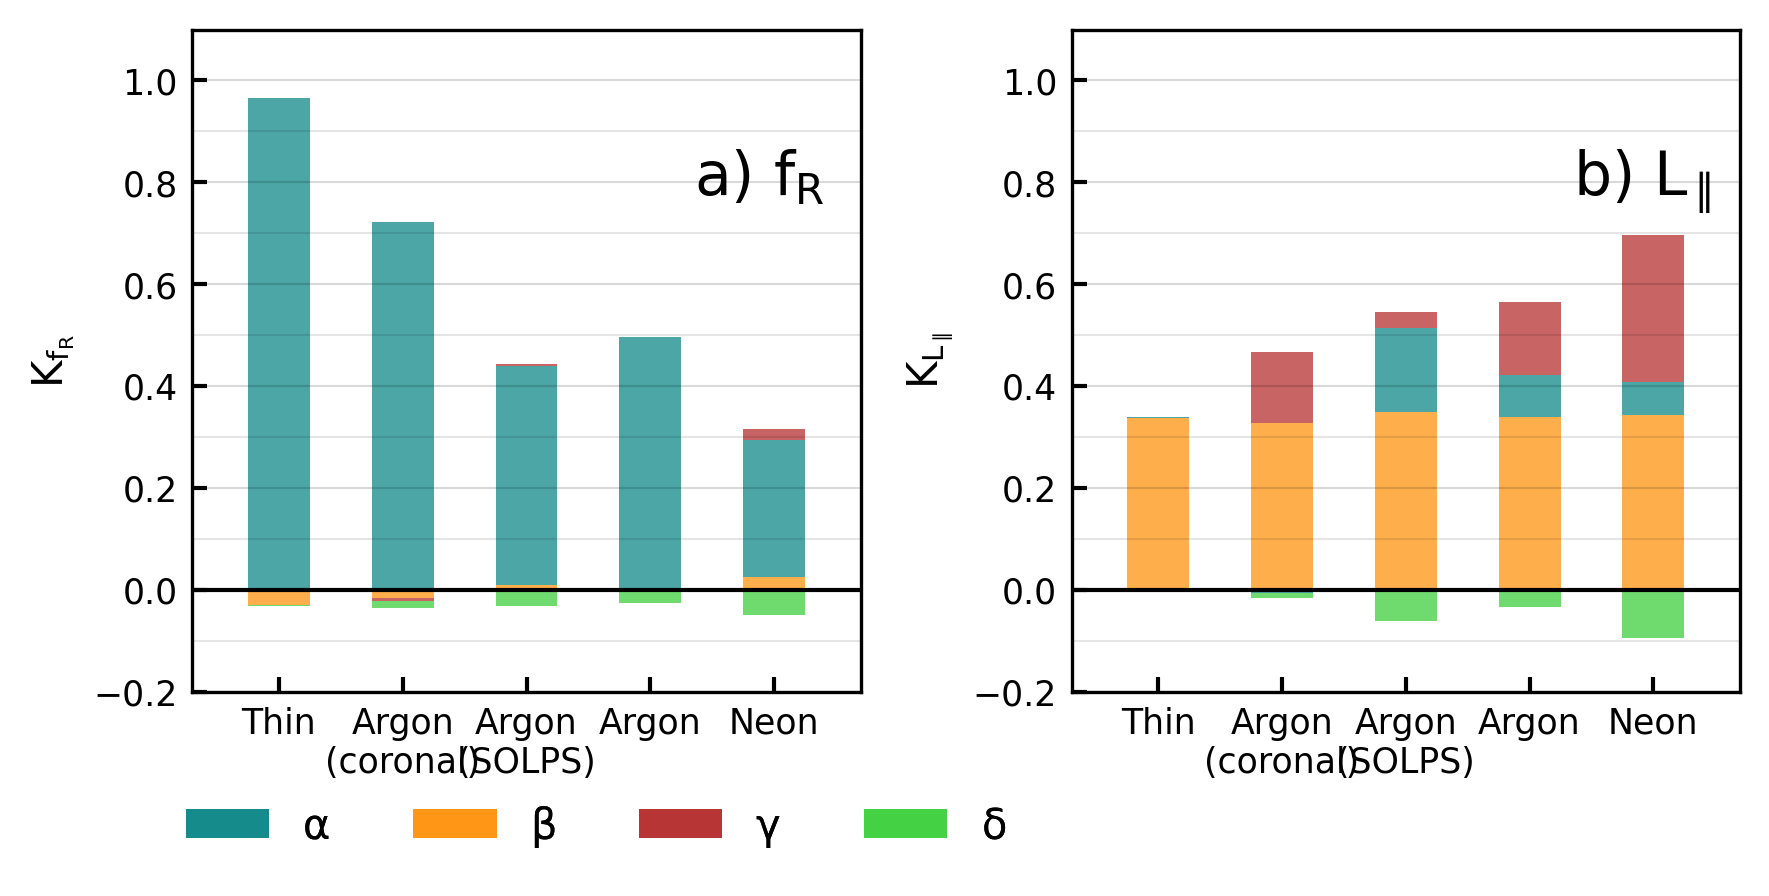

In [30]:
side = "outer"

fig, axes = plt.subplots(1,2, figsize = (6,2.8), dpi = 300)

for i, study in enumerate(studies[::-1]):
    ax = axes[i]

    plot_weights = all_plotweights[study].reindex(["W_Tu", "Beff", "curveclip", "upstream_rad"])
    weight_counts_pos = {}
    weight_counts_neg = {}
    for param in plot_weights.index:
        weight_counts_neg[param] = plot_weights[plot_weights < 0].fillna(0).loc[param, :]
        weight_counts_pos[param] = plot_weights[plot_weights > 0].fillna(0).loc[param, :]
        
    bottom_pos = np.zeros_like(weight_counts_pos[param])
    bottom_neg = np.zeros_like(weight_counts_pos[param])

    width = 0.5
    for param, weight_counts_neg in weight_counts_neg.items():
        p = ax.bar(curves[f"set_{side}"].keys(), weight_counts_neg, width, bottom = bottom_neg, alpha = bar_alpha, color = param_colors[param])
        bottom_neg += weight_counts_neg
        
    for param, weight_counts_pos in weight_counts_pos.items():
        p = ax.bar(curves[f"set_{side}"].keys(), weight_counts_pos, width, bottom = bottom_pos, alpha = bar_alpha, color = param_colors[param])
        bottom_pos += weight_counts_pos
        
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.grid(axis = "x", which = "both", visible = False)
    ax.grid(axis = "y", which = "major", c = "k", alpha = 0.15)
    ax.grid(axis = "y", which = "minor", c = "k", alpha = 0.1)
    ax.set_ylim(-0.2, 1.1)
    xlim = ax.get_xlim()
    ax.hlines(0, *xlim, color = "k", lw = 1, linestyle = "-")
    ax.set_xlim(xlim)
    
    fig.legend(handles=handles, ncols = 4, loc = "upper left", bbox_to_anchor = (0.1, 0.05), frameon = False)
    # fig.legend(handles=handles_line, ncols = 1, loc = "upper left", bbox_to_anchor = (0.65, 0), frameon = False)
    ax.set_ylabel(ylabels[study])
    ax.text(0.75, 0.75, titles[study], fontsize = "x-large", transform=ax.transAxes)
    xlim = ax.get_xlim()
    
    # ax.hlines(analytical.loc["simple", study], *xlim, color = "deeppink", lw = 2, linestyle = ":")
    # ax.hlines(analytical.loc["full", study], *xlim, color = "black", lw = 2, linestyle = ":")
    ax.tick_params(axis = "both", labelsize = "small")
    # ax.set_title(titles[study], loc = "right", transform=ax.transAxes)


fig.tight_layout()
# fig.savefig(fr"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_K_{side}_lower.pdf", format = "pdf")

# Scalings breakdown - inner

## Inner plot

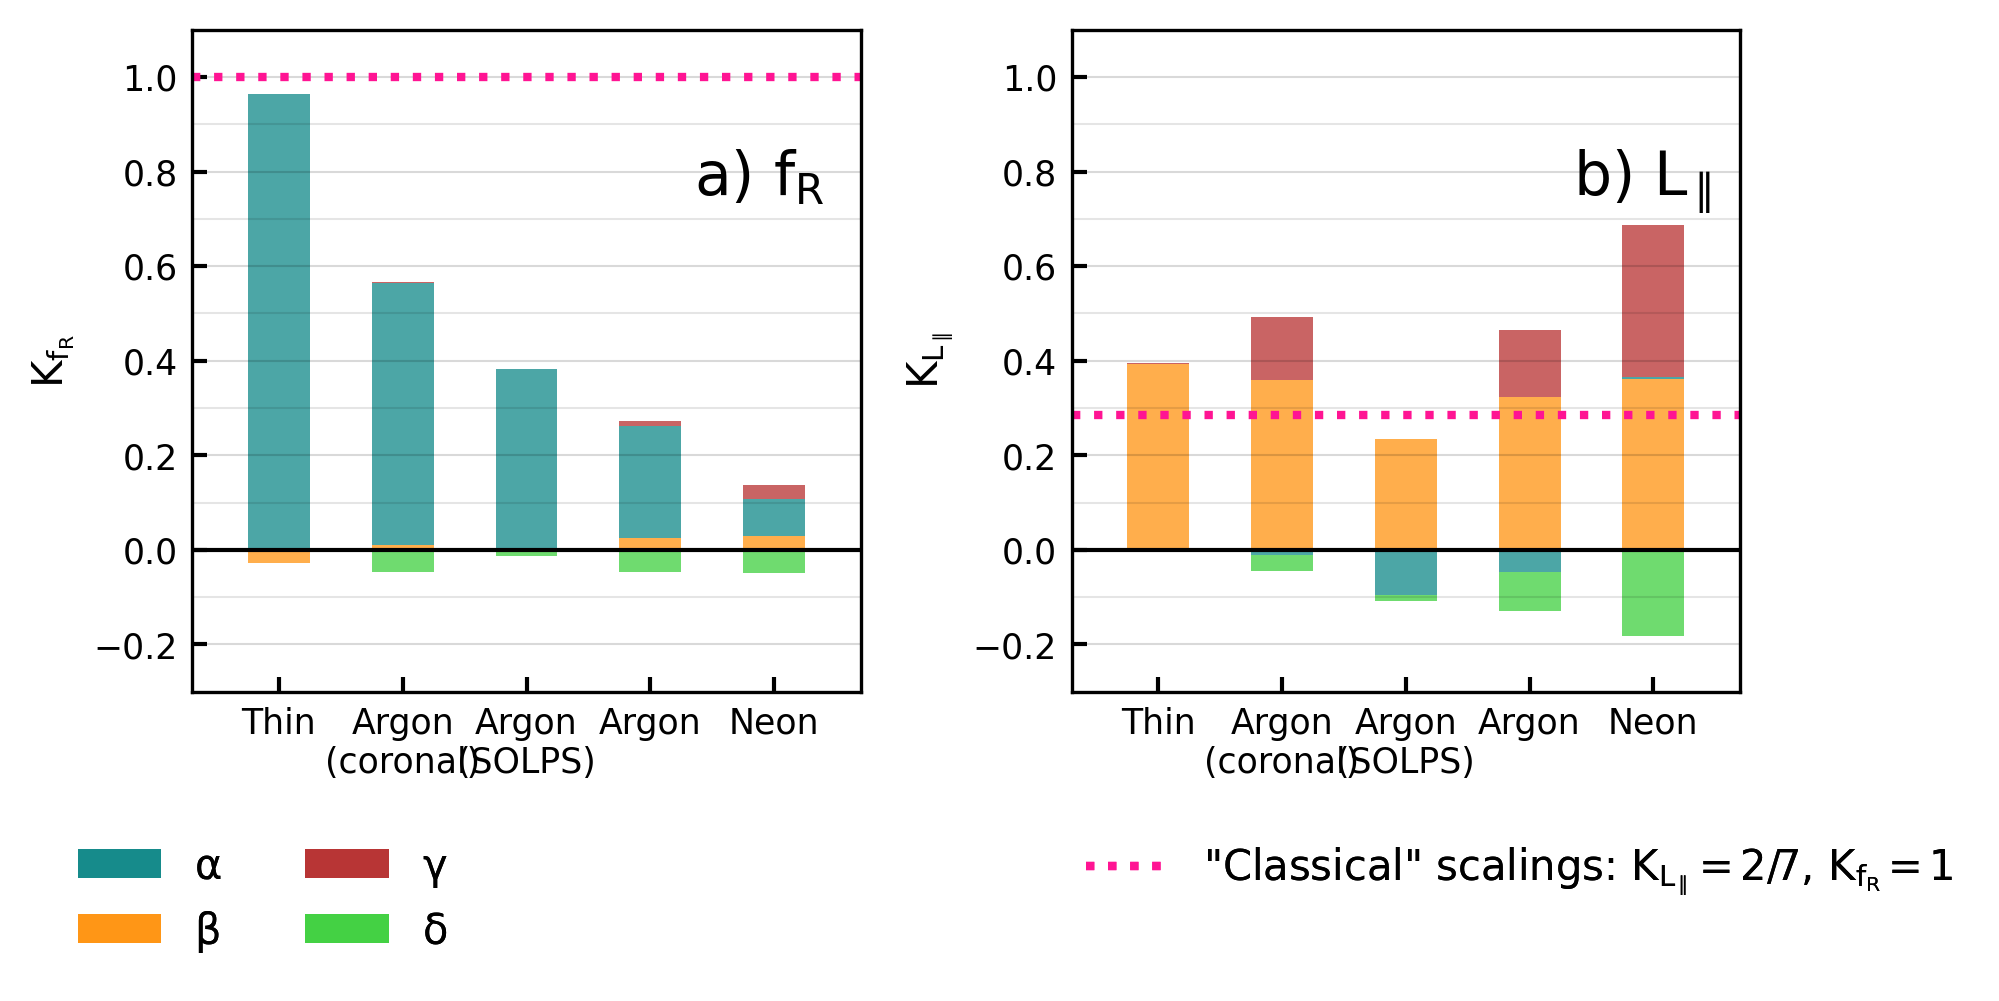

In [31]:
# param = "Lc"
# study_name = "Lc"

param = "BxBt"
study_name = "fR"
side = "inner"

store_choices = dict(inner = store_inner, outer = store_outer)
comps_choices = dict(inner = comps_inner, outer = comps_outer)


allchecks = {}
allterms = {}
allsc = {}
all_plotweights = {}

analytical = pd.DataFrame()

params = ["Lc", "BxBt"]
studies = ["Lc", "fR"]
# studies = ["Lc"]
all_allsc = {}

for i, study in enumerate(studies):
    param = params[i]
    plot_weights = pd.DataFrame()
    all_allsc[study] = {}

    for curve_name in curves[f"set_{side}"].keys():

        store = store_choices[side][study][curve_name]
        names = list(store.keys())

        sc = scaling_comparison(store[names[0]], store[names[-1]], param)
        allsc[curve_name] = sc
        all_allsc[study][curve_name] = sc
        allterms[curve_name] = sc.terms.copy()
        allchecks[curve_name] = sc.terms_check.copy()
        plot_weights[curve_name] = sc.terms["weights"]
        
        # print(f"Study {study}, Curve {curve_name}")
        # display(sc.terms)
        
        
    all_plotweights[study] = plot_weights
        
    ## Calculate analytical results for just Lpar/fR and for full analytical DLS with upstream and avgB ratio
    ratio = sc.terms_full["ratio"]
    param_ratio = ratio[param]
    simple = ratio["BxBt"] * ratio["Lc"]**(2/7)
    simple_avgB = ratio["BxBt"] * ratio["Lc"]**(2/7) * ratio["avgB_ratio"]**(-2/7)
    full = ratio["BxBt"] * ratio["Lc"]**(2/7) * ratio["avgB_ratio"]**(-2/7) * ratio["W_Tu_simple"]**(-1)
    
    analytical.loc["simple", study] = np.log(simple) / np.log(param_ratio)
    analytical.loc["simple_avgB", study] = np.log(simple_avgB) / np.log(param_ratio)
    analytical.loc["full", study] = np.log(full) / np.log(param_ratio)
        
fig, axes = plt.subplots(1,2, figsize = (6,2.8), dpi = 300)

for i, study in enumerate(studies[::-1]):
    ax = axes[i]

    plot_weights = all_plotweights[study].reindex(["W_Tu", "Beff", "curveclip", "upstream_rad"])
    weight_counts_pos = {}
    weight_counts_neg = {}
    for param in plot_weights.index:
        weight_counts_neg[param] = plot_weights[plot_weights < 0].fillna(0).loc[param, :]
        weight_counts_pos[param] = plot_weights[plot_weights > 0].fillna(0).loc[param, :]
        
    bottom_pos = np.zeros_like(weight_counts_pos[param])
    bottom_neg = np.zeros_like(weight_counts_pos[param])

    width = 0.5
    for param, weight_counts_neg in weight_counts_neg.items():
        p = ax.bar(curves[f"set_{side}"].keys(), weight_counts_neg, width, bottom = bottom_neg, alpha = bar_alpha, color = param_colors[param])
        bottom_neg += weight_counts_neg
        
    for param, weight_counts_pos in weight_counts_pos.items():
        p = ax.bar(curves[f"set_{side}"].keys(), weight_counts_pos, width, bottom = bottom_pos, alpha = bar_alpha, color = param_colors[param])
        bottom_pos += weight_counts_pos
        
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.grid(axis = "x", which = "both", visible = False)
    ax.grid(axis = "y", which = "major", c = "k", alpha = 0.15)
    ax.grid(axis = "y", which = "minor", c = "k", alpha = 0.1)
    ax.set_ylim(-0.3, 1.1)
    xlim = ax.get_xlim()
    ax.hlines(0, *xlim, color = "k", lw = 1, linestyle = "-")
    ax.set_xlim(xlim)
    
    fig.legend(handles=handles, ncols = 2, loc = "upper left", bbox_to_anchor = (0.04, 0.0), frameon = False)
    fig.legend(handles=handles_line, ncols = 1, loc = "upper left", bbox_to_anchor = (0.6, 0), frameon = False)
    ax.set_ylabel(ylabels[study])
    ax.text(0.75, 0.75, titles[study], fontsize = "x-large", transform=ax.transAxes)
    xlim = ax.get_xlim()
    
    ax.hlines(analytical.loc["simple", study], *xlim, color = "deeppink", lw = 2, linestyle = ":")
    # ax.hlines(analytical.loc["full", study], *xlim, color = "black", lw = 2, linestyle = ":")
    ax.tick_params(axis = "both", labelsize = "small")
    # ax.set_title(titles[study], loc = "right", transform=ax.transAxes)

all_plotweights_inner = all_plotweights
fig.tight_layout()
# fig.savefig(fr"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_K_{side}_lower.pdf", format = "pdf")
        

# Combined inner-outer plot

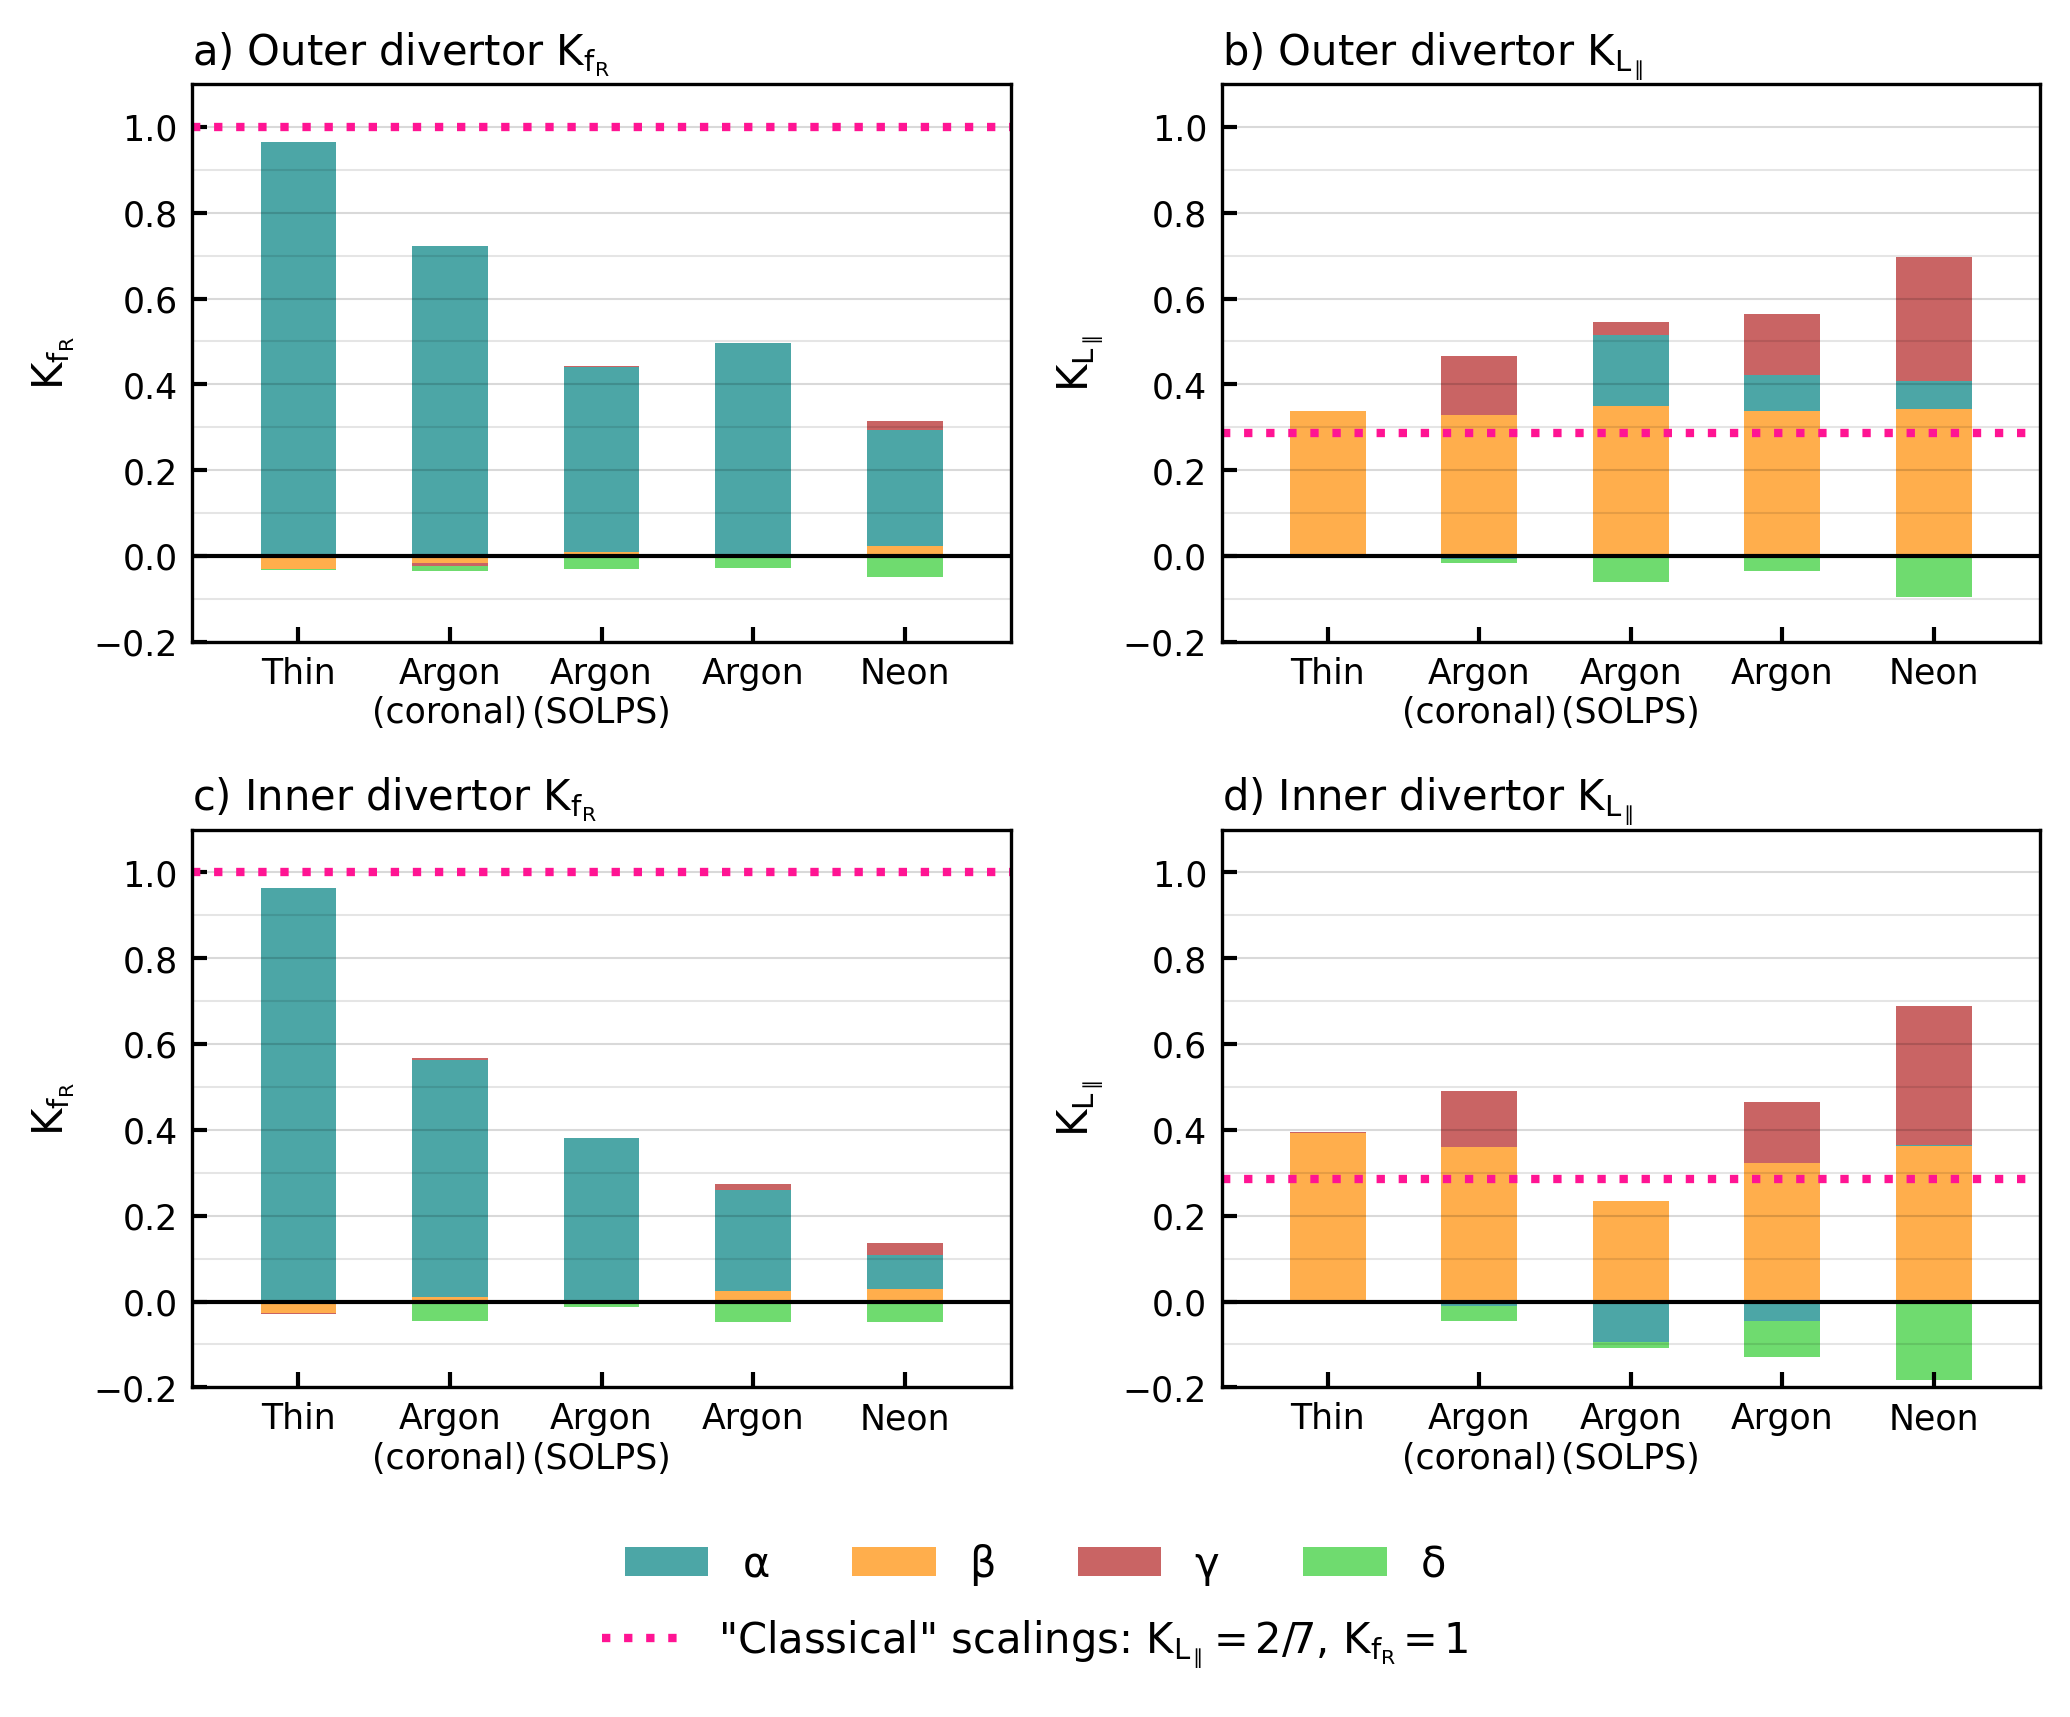

In [32]:
side = "inner"

disable_solps = False

fig, axes = plt.subplots(2,2, figsize = (7,3.2*2*0.8), dpi = 300)

for side_id, side in enumerate(["outer", "inner"]):
    for i, study in enumerate(studies[::-1]):
        ax = axes[side_id, i]

        all_plotweights = all_plotweights_outer if side == "outer" else all_plotweights_inner
        plot_weights = all_plotweights[study].reindex(["W_Tu", "Beff", "curveclip", "upstream_rad"])
        if disable_solps:
            plot_weights = plot_weights.drop("SOLPS", axis = 1)
        weight_counts_pos = {}
        weight_counts_neg = {}
        for param in plot_weights.index:
            weight_counts_neg[param] = plot_weights[plot_weights < 0].fillna(0).loc[param, :]
            weight_counts_pos[param] = plot_weights[plot_weights > 0].fillna(0).loc[param, :]
            
        bottom_pos = np.zeros_like(weight_counts_pos[param])
        bottom_neg = np.zeros_like(weight_counts_pos[param])

        width = 0.5
        curvenames = list(curves[f"set_{side}"].keys())
        if disable_solps:
            curvenames = [c for c in curvenames if c != "SOLPS"]
        
        for param, weight_counts_neg in weight_counts_neg.items():
            p = ax.bar(curvenames, weight_counts_neg, width, bottom = bottom_neg, alpha = bar_alpha, color = param_colors[param])
            bottom_neg += weight_counts_neg
            
        for param, weight_counts_pos in weight_counts_pos.items():
            p = ax.bar(curvenames, weight_counts_pos, width, bottom = bottom_pos, alpha = bar_alpha, color = param_colors[param])
            bottom_pos += weight_counts_pos
            
        ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
        ax.grid(axis = "x", which = "both", visible = False)
        ax.grid(axis = "y", which = "major", c = "k", alpha = 0.15)
        ax.grid(axis = "y", which = "minor", c = "k", alpha = 0.1)
        ax.set_ylim(-0.2, 1.1)
        xlim = ax.get_xlim()
        ax.hlines(0, *xlim, color = "k", lw = 1, linestyle = "-")
        ax.set_xlim(xlim)
        
        ax.set_ylabel(ylabels[study])
        # ax.text(0.75, 0.75, titles[study], fontsize = "x-large", transform=ax.transAxes)
        xlim = ax.get_xlim()
        
        ax.hlines(analytical.loc["simple", study], *xlim, color = "deeppink", lw = 2, linestyle = ":")
        # ax.hlines(analytical.loc["full", study], *xlim, color = "black", lw = 2, linestyle = ":")
        ax.tick_params(axis = "both", labelsize = "small")
        # ax.set_title(titles[study], loc = "right", transform=ax.transAxes)

titley = 0.99
titlex = 0
titleloc = "left"
axes[0,0].set_title(r"a) Outer divertor $K_{f_R}$", loc = titleloc, x = titlex, y=titley, fontsize = "medium")
axes[0,1].set_title(r"b) Outer divertor $K_{L_{\parallel}}$", loc = titleloc, x = titlex, y=titley, fontsize = "medium")
axes[1,0].set_title(r"c) Inner divertor $K_{f_R}$", loc = titleloc, x = titlex, y=titley, fontsize = "medium")
axes[1,1].set_title(r"d) Inner divertor $K_{L_{\parallel}}$", loc = titleloc, x = titlex, y=titley, fontsize = "medium")
fig.legend(handles=handles, ncols = 4, loc = "upper center", bbox_to_anchor = (0.5, 0.0), frameon = False)
fig.legend(handles=handles_line, ncols = 1, loc = "upper center", bbox_to_anchor = (0.5, -0.05), frameon = False)
fig.tight_layout()

fig.savefig(fr"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_KfR_KLpar.pdf", format = "pdf")

# Front widths plot

In [65]:
curves["set_inner"]

{'Thin': <function __main__.<lambda>(temp)>,
 'Argon\n(coronal)': <scipy.interpolate._interpolate.interp1d at 0x29b30505e50>,
 'Argon\n(SOLPS)': <function code_comparison.solps_pp.SOLPScase.extract_cooling_curve.<locals>.fit(T)>,
 'Argon': <scipy.interpolate._interpolate.interp1d at 0x29b30505d10>,
 'Neon': <scipy.interpolate._interpolate.interp1d at 0x29b30505fe0>}

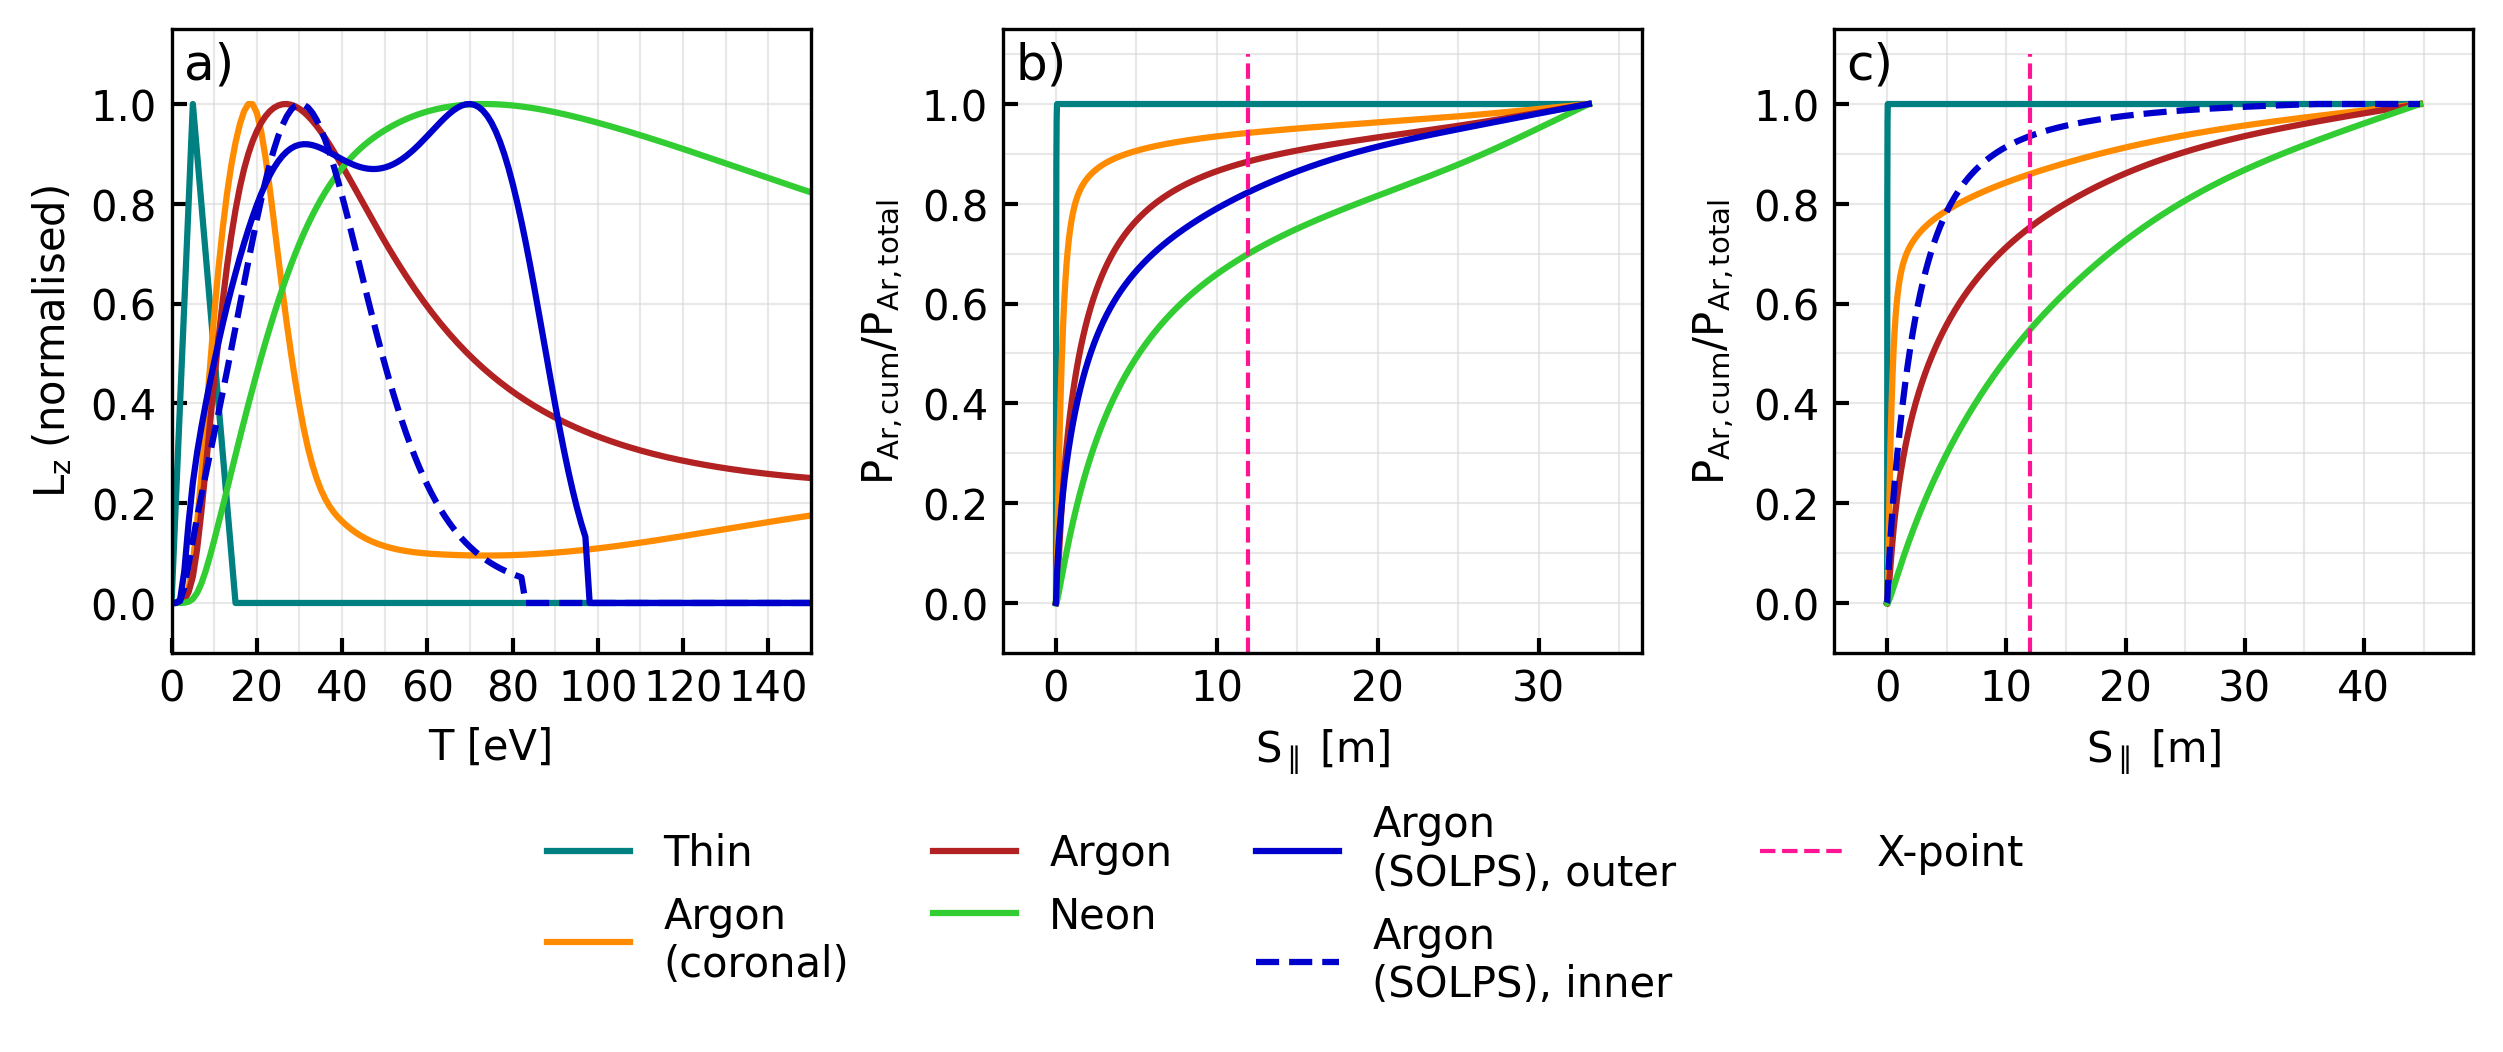

In [56]:

fig, axes = plt.subplots(1,3,figsize = (11*0.9,3*0.9), dpi = 300)

for curve in curves[f"set_inner"].keys():
    i = 1
    # for fR in store_profiles["fR"].keys():
    
    # comps_inner[study][curve][i] = comp
    if curve != "Argon\n(SOLPS)":
        
        Lz = [curves["set_inner"][curve](temp) for temp in T]
        Lz = Lz/np.max(Lz)
        
        axes[0].plot(T, Lz)
        
        comp = comps_outer["Lc"][curve][i]
        dls = comp.dls
        axes[1].plot(dls["Spar"], dls["Qrad_cum_norm"], label = curve)
        
        comp = comps_inner["Lc"][curve][i]
        dls = comp.dls
        axes[2].plot(dls["Spar"], dls["Qrad_cum_norm"])
        
Lz = [curves["set_outer"]["Argon\n(SOLPS)"](temp) for temp in T]
Lz = Lz/np.max(Lz)
axes[0].plot(T, Lz, color = "C4")

Lz = [curves["set_inner"]["Argon\n(SOLPS)"](temp) for temp in T]
Lz = Lz/np.max(Lz)
axes[0].plot(T, Lz, color = "C4", ls = "--")
        
dls = comps_outer["Lc"]["Argon\n(SOLPS)"][1].dls
axes[1].plot(dls["Spar"], dls["Qrad_cum_norm"], label = "Argon\n(SOLPS), outer")

dls = comps_inner["Lc"]["Argon\n(SOLPS)"][1].dls
axes[2].plot(dls["Spar"], dls["Qrad_cum_norm"], label = "Argon\n(SOLPS), inner", ls = "--")

for i, ax in enumerate([axes[1], axes[2]]):
    x = dls[dls["Xpoint"]==1].squeeze()
    ylim = ax.get_ylim()
    if i == 1:
        ax.vlines(x["Spar"], *ylim, lw = 1, ls = "--", color = "deeppink", label = "X-point")
    else:
        ax.vlines(x["Spar"], *ylim, lw = 1, ls = "--", color = "deeppink")
        
    ax.set_ylim(ylim)
    ax.set_xlabel(r"$S_{\parallel}$ [m]")
    ax.set_ylabel("$P_{Ar,cum}/P_{Ar,total}$")
    
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

axes[0].set_title("a)", loc = "left", x = 0.02, y = 0.88)
# axes[0].set_
axes[0].set_xlim(0,150)
axes[0].xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
axes[0].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
axes[0].set_ylabel(r"$L_{z}\ (normalised)$")

for ax in axes:
 ax.grid(axis = "both", which = "both")
 ax.set_ylim(None, 1.15)
axes[0].set_xlabel("T [eV]")

axes[1].set_title("b)", loc = "left", x = 0.02, y = 0.88)
axes[2].set_title("c)", loc = "left", x = 0.02, y = 0.88)

fig.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.05), ncol = 4, frameon = False)
fig.subplots_adjust(wspace = 0.3)

fig.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_curves_frontwidths.pdf", format = "pdf")
                                   

# Visualising terms

In [53]:
cases = {
    "Thin curve": FrontLocation(store_outer["fR"]["Thin"][2]),
    "Neon curve": FrontLocation(store_outer["fR"]["Neon"][2]),
}


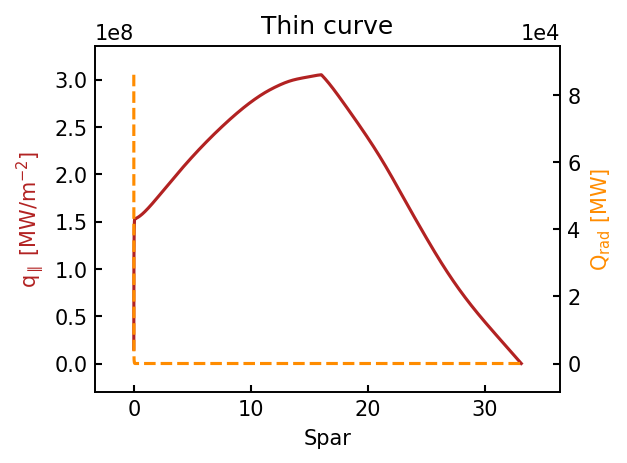

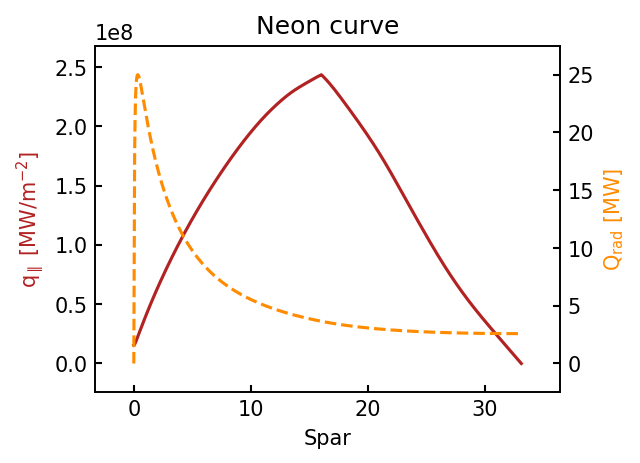

In [54]:
for name, out in cases.items():
    dls = out.data
    fig, ax = plt.subplots(figsize = (4,3), dpi = 150)
    ax.plot(dls["Spar"], dls["qpar"], c = "firebrick", label = r"$B_{tot}$ [T]")
    ax2 = ax.twinx()
    ax2.plot(dls["Spar"], dls["Qrad"]*1e-6, ls = "--", color = "darkorange", label = r"$Q_{rad}$")
    # fig.legend(loc = "upper left", bbox_to_anchor = (0.65,0.85))
    ax.set_xlabel("Spar")
    ax.set_ylabel(r"$q_{\parallel}$ [MW/$m^{-2}$]", color = "firebrick")
    ax2.set_ylabel("$Q_{rad}$ [MW]", color = "darkorange")
    ax.set_title(f"{name}")

# dls.plot(mode = "")


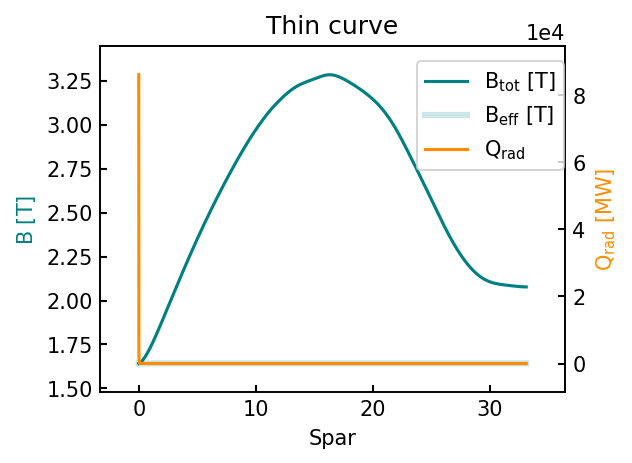

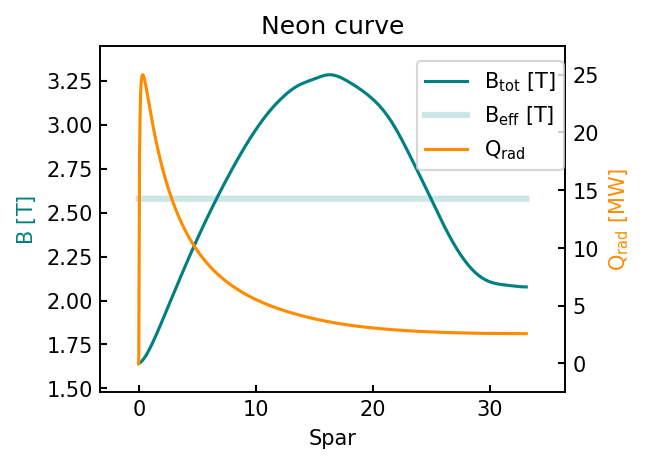

In [55]:
for name, out in cases.items():
    dls = out.data

    dls["Beff"] = np.sqrt(
        sp.integrate.trapezoid(y=dls["qpar"] * dls["Qrad"], x=dls["Spar"])
        / sp.integrate.trapezoid(y=dls["qpar"] * dls["Qrad"] / dls["Btot"]**2, x=dls["Spar"])
    )

    # dls["Beff"] = np.sqrt((dls["qpar"] * dls["Qrad"])) / np.sqrt((dls["qpar"] * dls["Qrad"] / dls["Btot"]**2))

    fig, ax = plt.subplots(figsize = (4,3), dpi = 150)

    ax.plot(dls["Spar"], dls["Btot"], label = r"$B_{tot}$ [T]")
    ax.plot(dls["Spar"], dls["Beff"], color = "teal", label = r"$B_{eff}$ [T]", lw = 3, alpha = 0.2)

    ax2 = ax.twinx()
    ax2.plot(dls["Spar"], dls["Qrad"]*1e-6, ls = "-", color = "darkorange", label = r"$Q_{rad}$")
    fig.legend(loc = "upper left", bbox_to_anchor = (0.65,0.85))
    ax.set_xlabel("Spar")
    ax.set_ylabel("$B$ [T]", color = "teal")
    ax2.set_ylabel("$Q_{rad}$ [MW]", color = "darkorange")
    ax.set_title(f"{name}")


Text(0, 0.5, '$T_{e}$ [eV]')

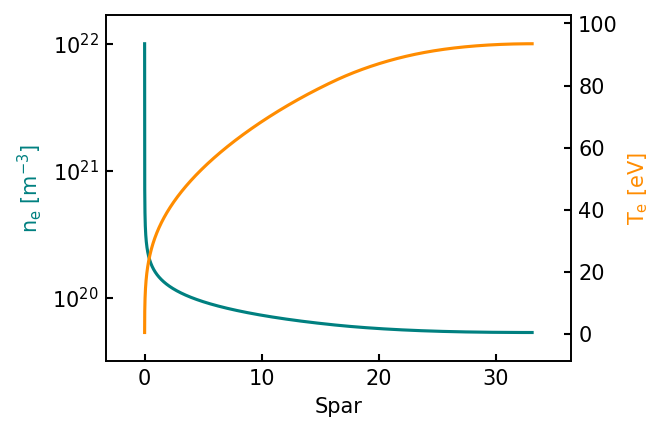

In [56]:
dls = cases["Thin curve"].data

fig, ax = plt.subplots(figsize = (4,3), dpi = 150)

ax.plot(dls["Spar"], dls["Ne"], label = r"$B_{tot}$ [T]")
ax.set_yscale("log")
# ax.plot(dls["Spar"], dls["Te"], color = "teal", label = r"$B_{eff}$ [T]", lw = 3, alpha = 0.2)

ax2 = ax.twinx()
ax2.plot(dls["Spar"], dls["Te"], ls = "-", color = "darkorange", label = r"$Q_{rad}$")

ax.set_xlabel("Spar")
ax.set_ylabel("$n_{e}$ [$m^{-3}$]", color = "teal")
ax2.set_ylabel("$T_{e}$ [eV]", color = "darkorange")
# ax.set_title(f"{name}")
# fig.legend(loc = "upper left", bbox_to_anchor = (0.65,0.85))

In [47]:
cases.keys()

dict_keys(['Thin curve', 'Neon curve'])

Text(0, 0.5, '$T_{e}$ [eV]')

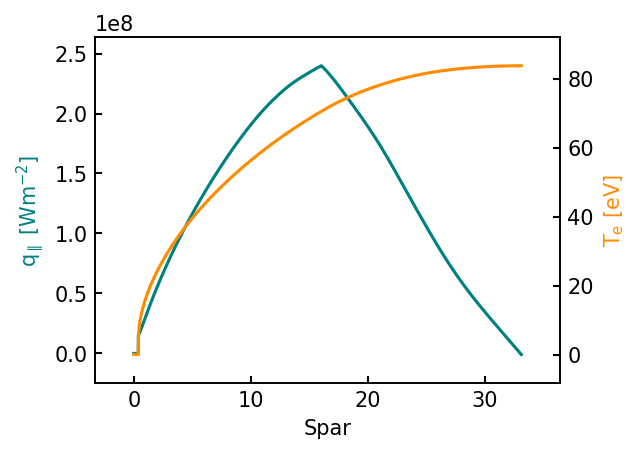

In [48]:
dls = cases["Neon curve"].data

fig, ax = plt.subplots(figsize = (4,3), dpi = 150)

ax.plot(dls["Spar"], dls["qpar"], label = r"$B_{tot}$ [T]")
# ax.set_yscale("log")
# ax.plot(dls["Spar"], dls["Te"], color = "teal", label = r"$B_{eff}$ [T]", lw = 3, alpha = 0.2)

ax2 = ax.twinx()
ax2.plot(dls["Spar"], dls["Te"], ls = "-", color = "darkorange", label = r"$Q_{rad}$")

ax.set_xlabel("Spar")
ax.set_ylabel(r"$q_{\parallel}$ [$Wm^{-2}$]", color = "teal")
ax2.set_ylabel("$T_{e}$ [eV]", color = "darkorange")
# ax.set_title(f"{name}")
# fig.legend(loc = "upper left", bbox_to_anchor = (0.65,0.85))

## Deep dive into scalings

### Debugging terms

In [ ]:
allterms = {}
terms = pd.DataFrame()
param = "Lc"
study_name = "Lc"

for curve_name in curves["set"].keys():
    profiles = store_profiles[study_name]
    stores = store_outer[study_name]
    
    store = stores[curve_name]
    names = list(store.keys())

    # Compare last and first case only!!
    df1 = DLScase(store[names[0]]).get_stats_dataframe()
    df2 = DLScase(store[names[-1]]).get_stats_dataframe()
    terms = pd.concat([df1, df2], axis = 0)
    terms.index = ["base", "test"]
    terms = terms.T
    terms = terms.loc[["Beff", "W_Tu", "int_TLz_dt", "int_qoverBsq_dt"],:]
    terms["ratio"] = terms["test"] / terms["base"]
    allterms[curve_name] = terms.copy()
    
    print(curve_name)
    display(terms)


SOLPS


,base,test,ratio
Beff,2.524755e+00,2.194245e+00,0.869092
W_Tu,1.825374e-01,1.402662e-01,0.768424
int_TLz_dt,1.264384e+12,1.247918e+12,0.986977
int_qoverBsq_dt,6.428822e+00,6.632497e+00,1.031681


Curve 1


,base,test,ratio
Beff,1.833435e+00,1.816788e+00,0.990920
W_Tu,1.724111e-01,1.374096e-01,0.796989
int_TLz_dt,7.628084e+12,7.768008e+12,1.018343
int_qoverBsq_dt,6.712429e+00,6.629385e+00,0.987628


Curve 2


,base,test,ratio
Beff,2.372208e+00,2.212314e+00,0.932597
W_Tu,1.809537e-01,1.415077e-01,0.782011
int_TLz_dt,1.386781e+12,1.250712e+12,0.901882
int_qoverBsq_dt,6.384594e+00,6.532351e+00,1.023143


Curve 3


,base,test,ratio
Beff,2.637184e+00,2.483448e+00,0.941705
W_Tu,1.907762e-01,1.462331e-01,0.766517
int_TLz_dt,1.102337e+12,8.945043e+11,0.811462
int_qoverBsq_dt,6.005550e+00,6.397781e+00,1.065311


## RESOLVE ANALYTICAL WITH UPSTREAM
- With upstream doesn't work

In [ ]:
analytical["Lc"]

,SOLPS,Curve 1,Curve 2,Curve 3
simple,0.285713,0.285713,0.285713,0.285713
simple_avgB,0.285706,0.285706,0.285706,0.285706
full,0.137256,0.137256,0.137256,0.137256


In [239]:
df = allsc["Curve 1"].terms_full.loc[["BxBt", "Lc", "avgB_ratio", "W_Tu_simple"]]
df.loc["BxBt", "factor"] = df["ratio"]["BxBt"]**(1)
df.loc["Lc", "factor"] = df["ratio"]["Lc"]**(2/7)
df.loc["avgB_ratio", "factor"] = df["ratio"]["avgB_ratio"]**(2/7)
df.loc["W_Tu_simple", "factor"] = df["ratio"]["W_Tu_simple"]**(-1)
df

,base,test,ratio,factor
BxBt,1.999993,3.999981,0.500001,0.500001
Lc,8.348459,8.348459,1.000000,1.000000
avgB_ratio,1.242008,1.412985,0.878996,0.963821
W_Tu_simple,0.347306,0.351230,0.988829,1.011298


In [242]:
store_outer[f"fR"]["Curve 1"].keys()

dict_keys([2, 4])

In [248]:
# Compare last and first case only!!
df1 = DLScase(store_outer[f"fR"]["Curve 1"][2]).get_stats_dataframe()
df2 = DLScase(store_outer[f"fR"]["Curve 1"][4]).get_stats_dataframe()
scaling = test_scalings(df1, df2, "BxBt", cumulative = True)

for col in scaling:
    if not any([name in col for name in ["result", "param_ratio"]]):
        scaling[col] = np.log(scaling[col]) / np.log(scaling["param_ratio"]) 
        
scaling

# for col in scaling.drop(["result", "param_ratio"], axis = 1).columns:
# exponents.loc[curve_name, col] = (np.log(1/scaling[col]) / np.log(scaling["param_ratio"])).values[0]

,result,param_ratio,simple_noavg_B,simple,abovex,Beff,W_Tu,curveclip,upstream_rad
0,0.51892,1.999997,-1.0,-0.946837,-0.930629,-0.939988,-0.92618,-0.925619,-0.925895


In [246]:
scaling

,result,param_ratio,simple_noavg_B,simple,abovex,Beff,W_Tu,curveclip,upstream_rad
0,0.51892,1.999997,0.500001,0.518769,0.52463,0.521238,0.52625,0.526455,0.526355


# Compare individual cases

In [ ]:
comps_outer["fR"]["Curve 1"][2].dls.keys()

Index(['Qrad', 'Spar', 'Spol', 'Te', 'qpar', 'Btot', 'cz', 'Ne', 'Xpoint',
       'qradial', 'Prad_per_area', 'Prad_per_area_cum',
       'Prad_per_area_cum_norm', 'Prad_cum', 'Prad_cum_norm', 'Pe', 'Ne_sq_cz',
       'qpar_cond_frac'],
      dtype='object')

## Small KLpar for inner SOLPS
- Compare to coronal argon

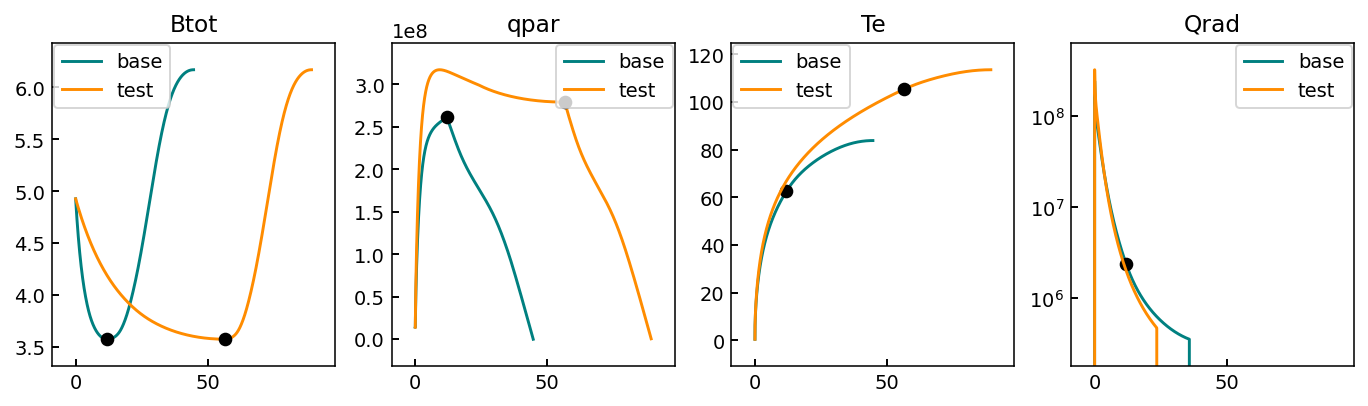

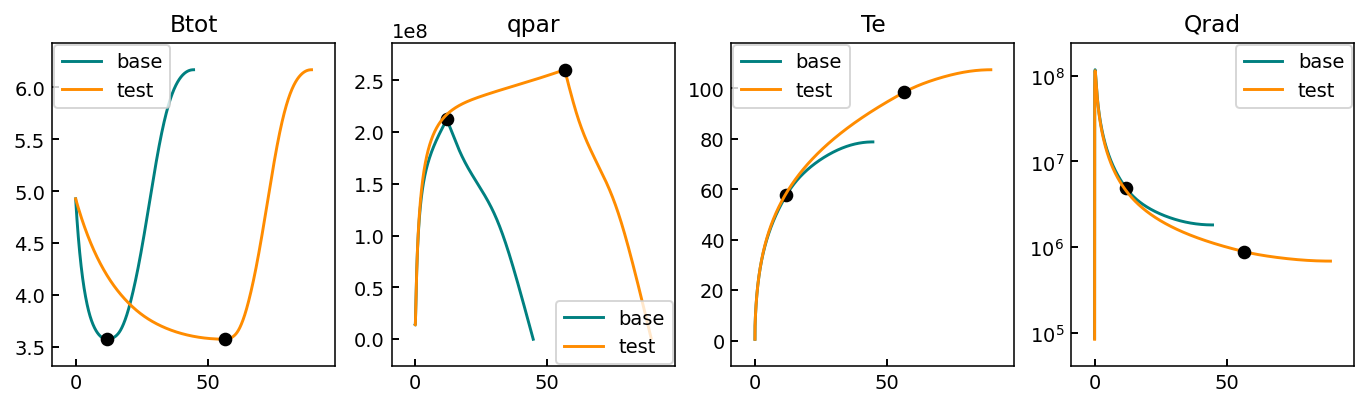

In [37]:
toplot = dict(
    base = comps_inner["Lc"]["Argon\n(SOLPS)"][1].dls,
    test = comps_inner["Lc"]["Argon\n(SOLPS)"][2].dls
)
params = ["Btot", "qpar", "Te", "Qrad"]

xlims_zoom = (0.25, 0.75)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

toplot = dict(
    base = comps_inner["Lc"]["Argon"][1].dls,
    test = comps_inner["Lc"]["Argon"][2].dls
)
params = ["Btot", "qpar", "Te", "Qrad"]

xlims_zoom = (0.25, 0.75)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

In [ ]:
### Compare to 

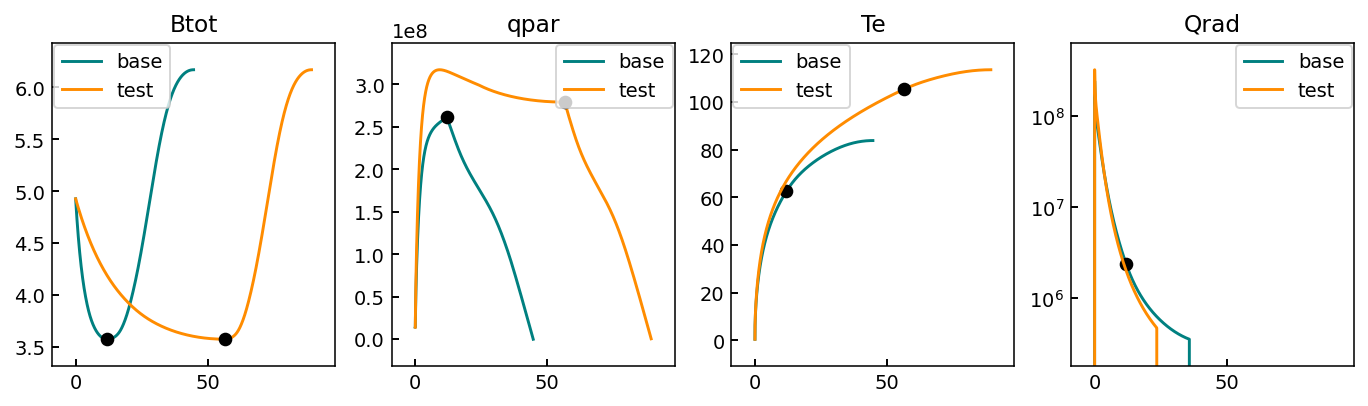

In [ ]:
toplot = dict(
    base = comps_inner["Lc"]["Argon\n(SOLPS)"][1].dls,
    test = comps_inner["Lc"]["Argon\n(SOLPS)"][2].dls
)
params = ["Btot", "qpar", "Te", "Qrad"]

xlims_zoom = (0.25, 0.75)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

## Term beta for SOLPS/thin curve in Lc

### Thin curve

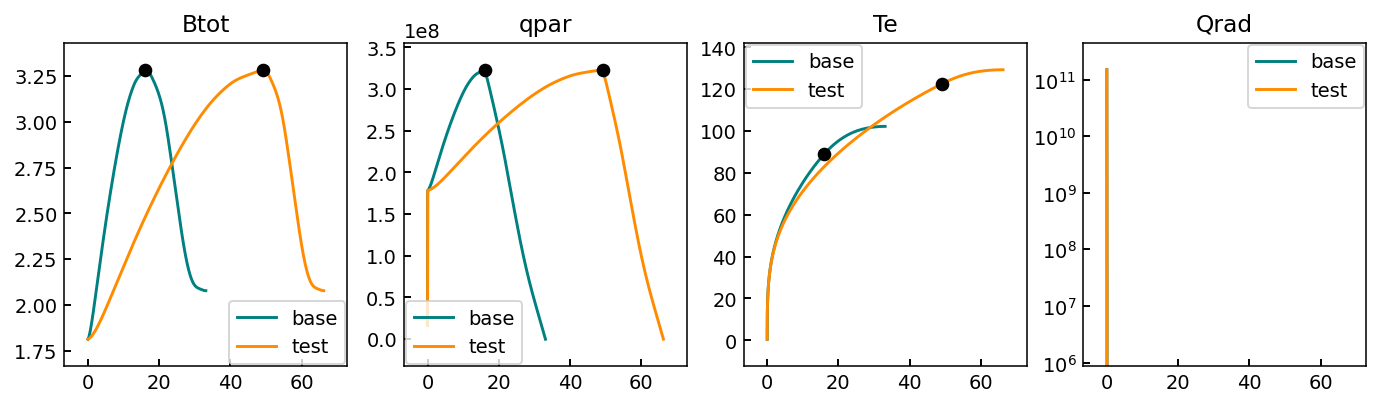

In [165]:
toplot = dict(
    base = comps_outer["Lc"]["Thin"][1].dls,
    test = comps_outer["Lc"]["Thin"][2].dls
)
params = ["Btot", "qpar", "Te", "Qrad"]

xlims_zoom = (0.25, 0.75)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

### Argon curve

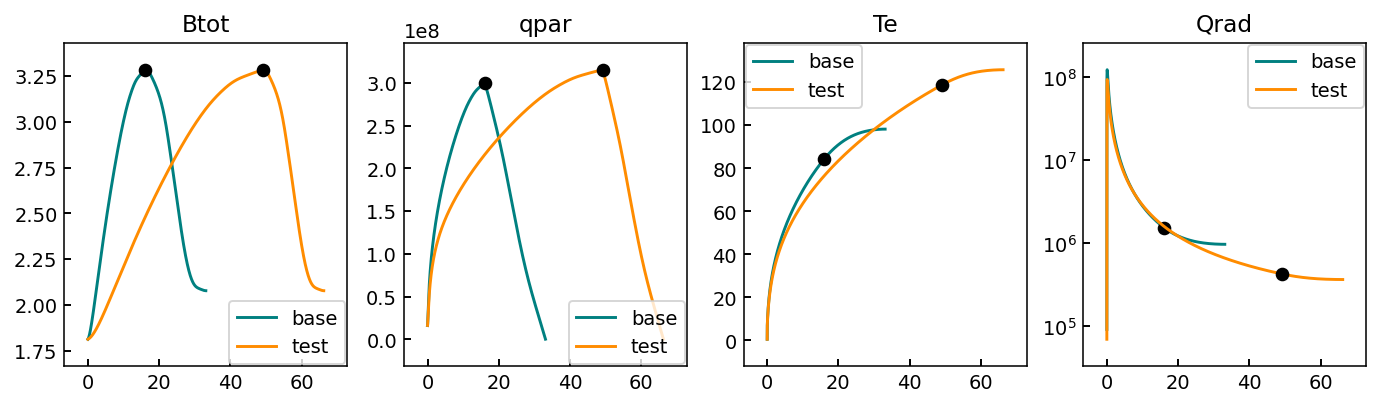

In [167]:
toplot = dict(
    base = comps_outer["Lc"]["Argon"][1].dls,
    test = comps_outer["Lc"]["Argon"][2].dls
)
params = ["Btot", "qpar", "Te", "Qrad"]

xlims_zoom = (0.25, 0.75)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

### SOLPS curve

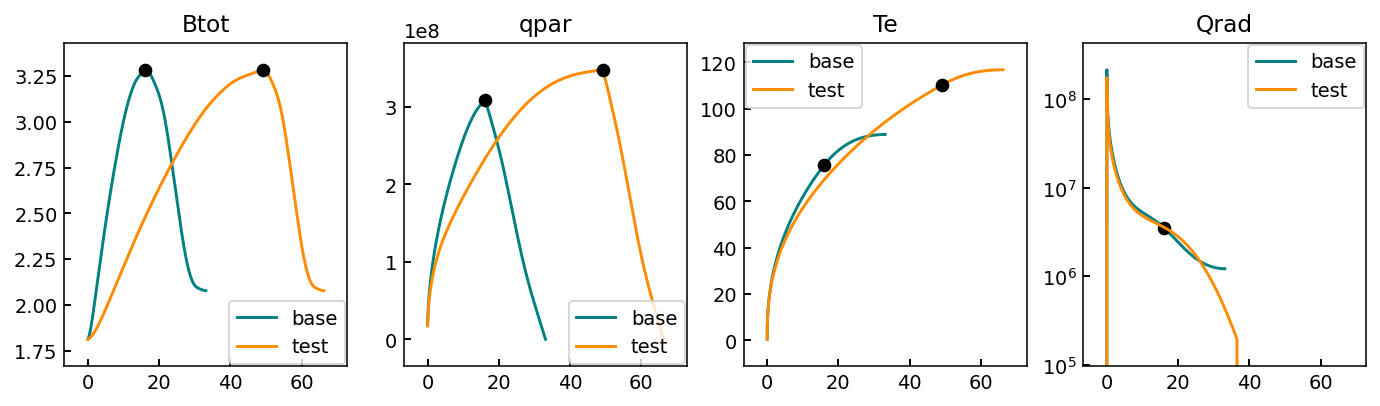

In [35]:
toplot = dict(
    base = comps_outer["Lc"]["Argon\n(SOLPS)"][1].dls,
    test = comps_outer["Lc"]["Argon\n(SOLPS)"][2].dls
)
params = ["Btot", "qpar", "Te", "Qrad"]

xlims_zoom = (0.25, 0.75)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

## Thin curve compared to analytical: fR

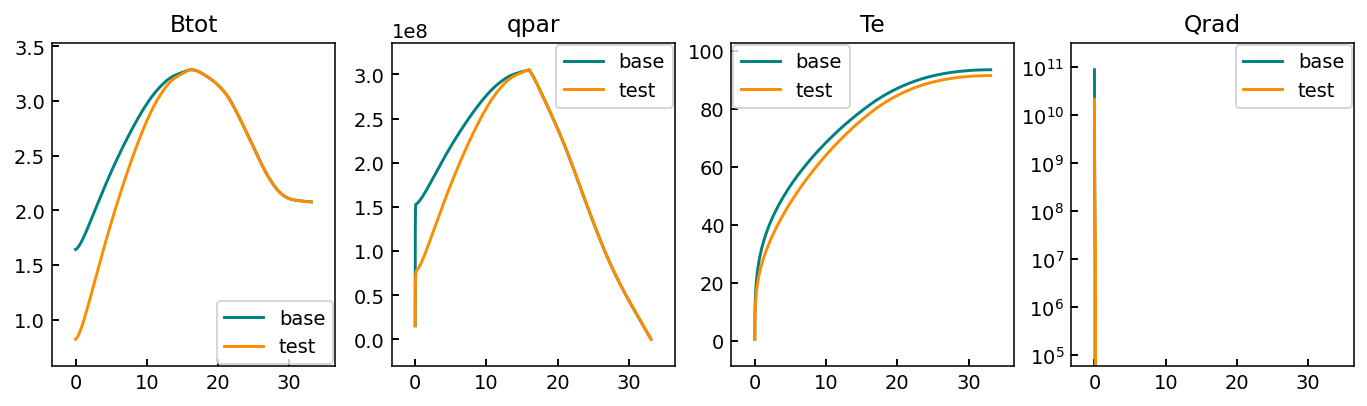

In [47]:
toplot = dict(
    base = comps_outer["fR"]["Thin"][2].dls,
    test = comps_outer["fR"]["Thin"][4].dls
)
params = ["Btot", "qpar", "Te", "Qrad"]

xlims_zoom = (0.25, 0.75)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

## Thin curve compared to analytical: Lc

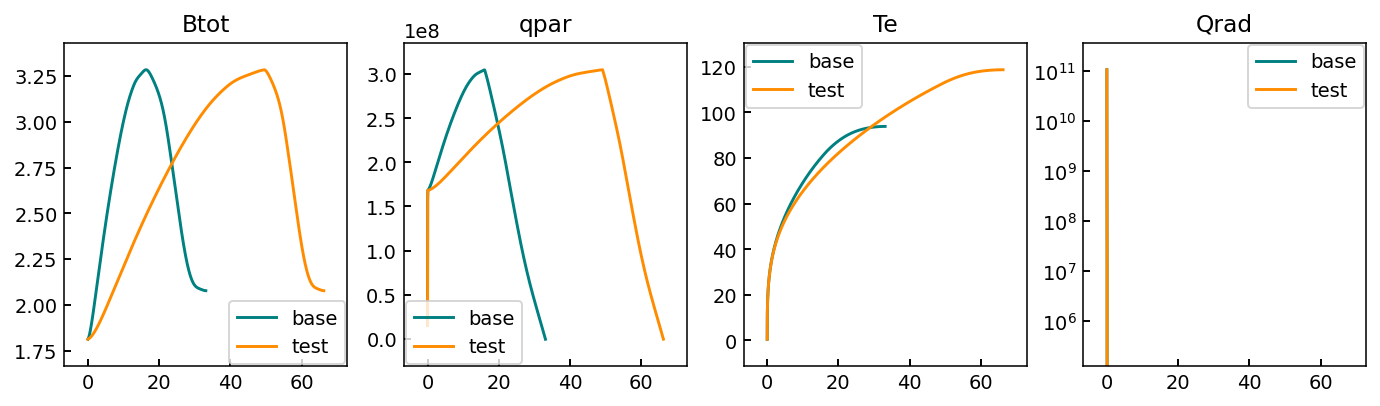

In [48]:
toplot = dict(
    base = comps_outer["Lc"]["Thin"][1].dls,
    test = comps_outer["Lc"]["Thin"][2].dls
)
params = ["Btot", "qpar", "Te", "Qrad"]

xlims_zoom = (0.25, 0.75)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

## KfR reducing for broader curves

In [53]:
store_outer["fR"][curve_name].keys()

dict_keys([2, 4])

In [54]:
df = pd.DataFrame()

for curve_name in curves["set_outer"].keys():
    outer_base = FrontLocation(store_outer["fR"][curve_name][2], 0).stats
    inner_base = FrontLocation(store_inner["fR"][curve_name][1], 0).stats
    outer_test = FrontLocation(store_outer["fR"][curve_name][4], 0).stats
    inner_test = FrontLocation(store_inner["fR"][curve_name][2], 0).stats
    
    df.loc[curve_name, "fR change"] = outer_test["BxBt"] / outer_base["BxBt"]
    df.loc[curve_name, "fR_eff change (outer)"] = outer_test["BxBteff"] / outer_base["BxBteff"]
    df.loc[curve_name, "fR_eff change (inner)"] = inner_test["BxBteff"] / inner_base["BxBteff"]
    
df.T

,Thin,Argon\n(coronal),Argon,Neon,SOLPS
fR change,1.999997,1.999997,1.999997,1.999997,1.999997
fR_eff change (outer),1.996738,1.718105,1.437004,1.246524,1.376825
fR_eff change (inner),1.992086,1.542479,1.219371,1.087164,1.315499


## KfR reducing for broader curves through alpha
- Why does alpha improve the outer and worsen the inner?

### Outer SOLPS

In [58]:
compare_dls?

Signature:
compare_dls(
    toplot,
    params,
    settings=defaultdict(<class 'dict'>, {'Btot': {}, 'qpar': {}, 'Te': {}, 'Qrad': {}}),
    xlims=defaultdict(<class 'dict'>, {}),
    scales=defaultdict(<class 'dict'>, {}),
)
Docstring: <no docstring>
File:      c:\users\mike\onedrive\project\python-packages\sdtools\dls\postprocess.py
Type:      function

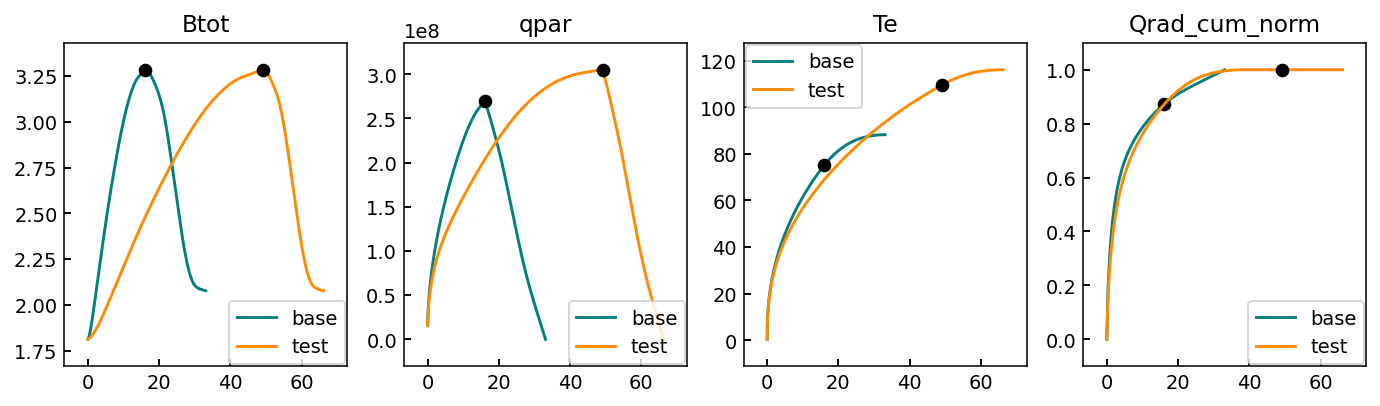

In [71]:
toplot = dict(
    base = comps_outer["Lc"]["SOLPS"][1].dls,
    test = comps_outer["Lc"]["SOLPS"][2].dls
)
params = ["Btot", "qpar", "Te", "Qrad_cum_norm"]

xlims_zoom = (0.25, 0.75)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

### Inner SOLPS

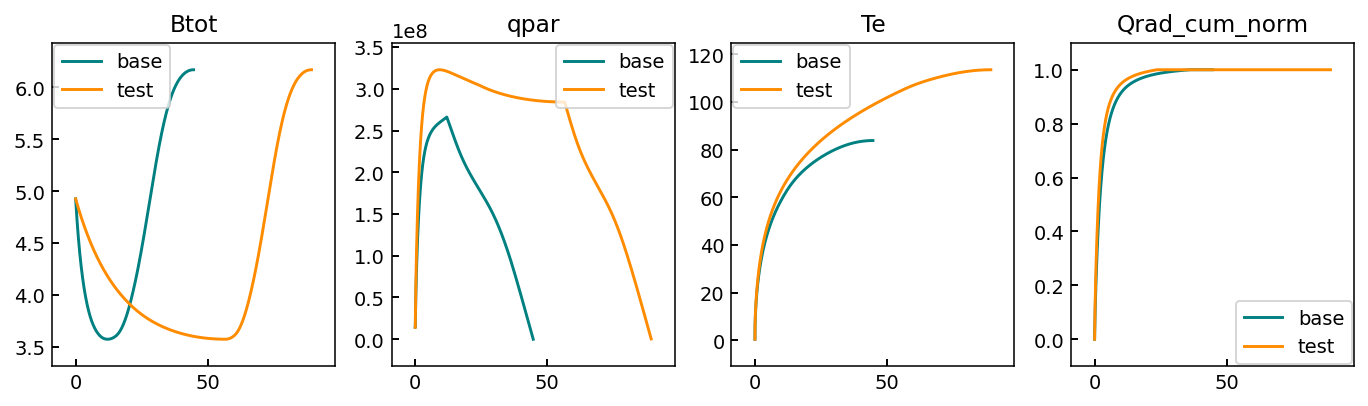

In [62]:
toplot = dict(
    base = comps_inner["Lc"]["SOLPS"][1].dls,
    test = comps_inner["Lc"]["SOLPS"][2].dls
)
params = ["Btot", "qpar", "Te", "Qrad_cum_norm"]

xlims_zoom = (0.25, 0.75)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

## fR Curve 1

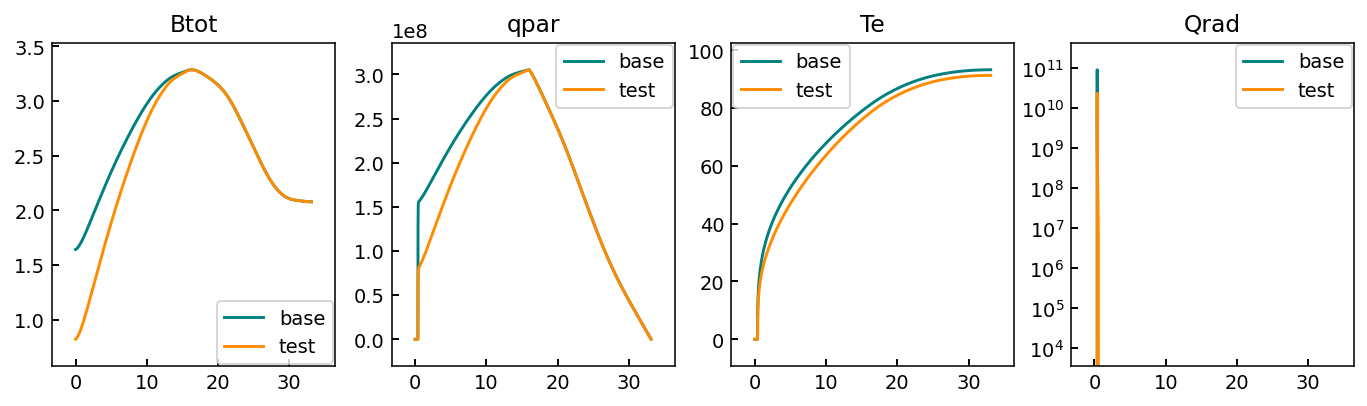

In [55]:

            
toplot = dict(
    base = comps_outer["fR"]["Thin"][2].dls,
    test = comps_outer["fR"]["Thin"][4].dls
)
params = ["Btot", "qpar", "Te", "Qrad"]

xlims_zoom = (0.25, 0.75)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

## Thin curve and Lpar scaling

In [57]:
comps_outer["Lc"]["Thin"].keys()

dict_keys([1, 2])

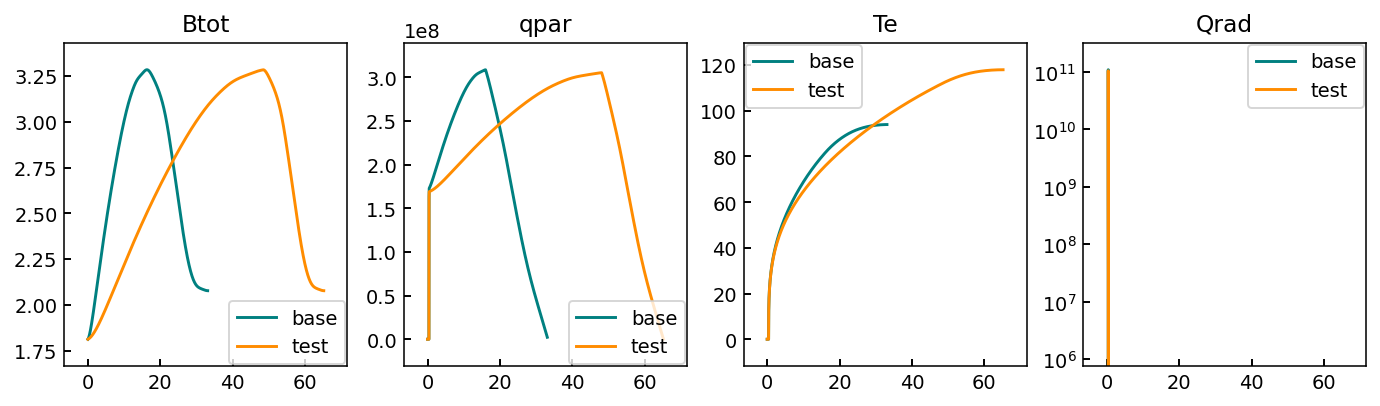

In [58]:
            
toplot = dict(
    base = comps_outer["Lc"]["Thin"][1].dls,
    test = comps_outer["Lc"]["Thin"][2].dls
)
params = ["Btot", "qpar", "Te", "Qrad"]

xlims_zoom = (0.25, 0.75)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

## fR Curve 2

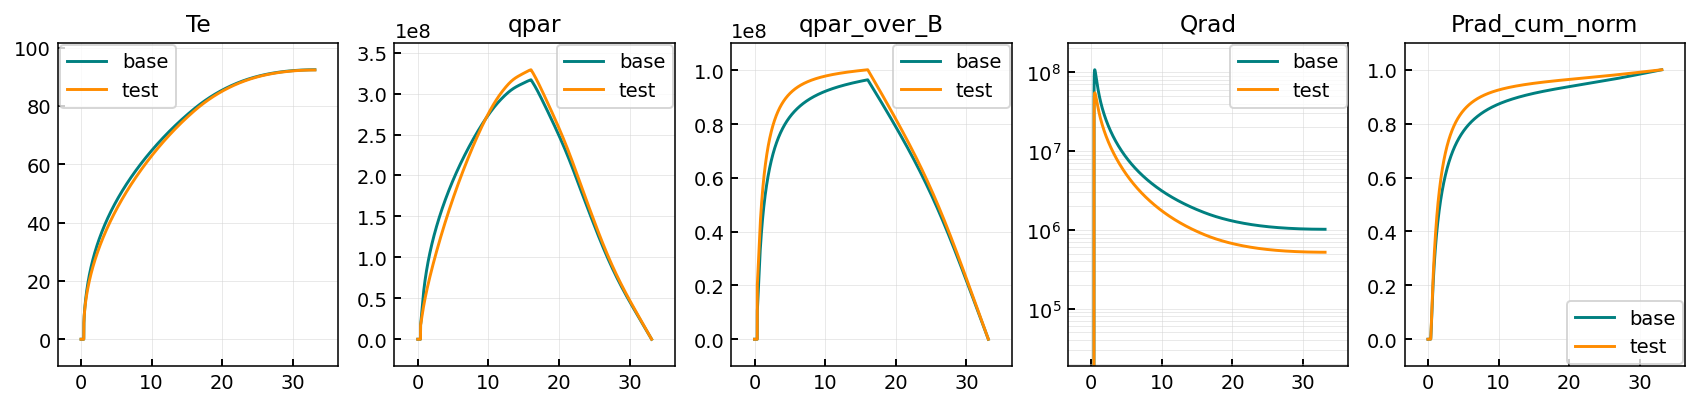

In [104]:
toplot = dict(
    base = comps_outer["fR"]["Curve 2"][2].dls,
    test = comps_outer["fR"]["Curve 2"][4].dls
)
params = ["Te", "qpar", "qpar_over_B", "Qrad", "Prad_cum_norm"]

xlims_zoom = (0, 35)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

## fR Curve 3

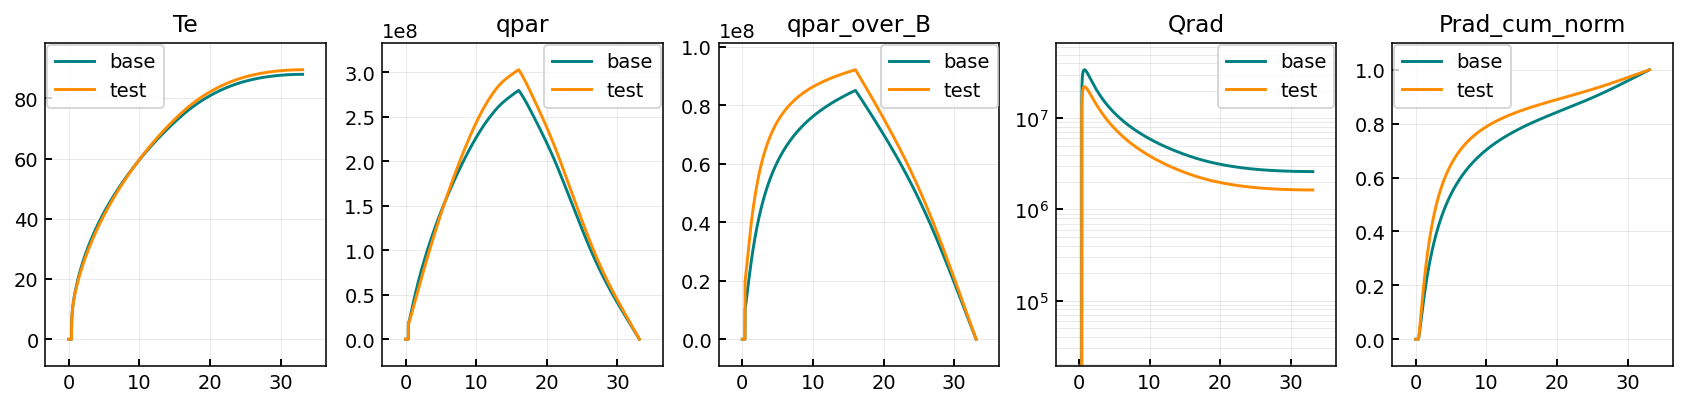

In [106]:
toplot = dict(
    base = comps_outer["fR"]["Curve 3"][2].dls,
    test = comps_outer["fR"]["Curve 3"][4].dls
)
params = ["Te", "qpar", "qpar_over_B", "Qrad", "Prad_cum_norm"]

xlims_zoom = (0, 35)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

## Inner: Lc Curve 1

In [141]:
comps_inner["Lc"]["Curve 1"].keys()

dict_keys([1, 1.5])

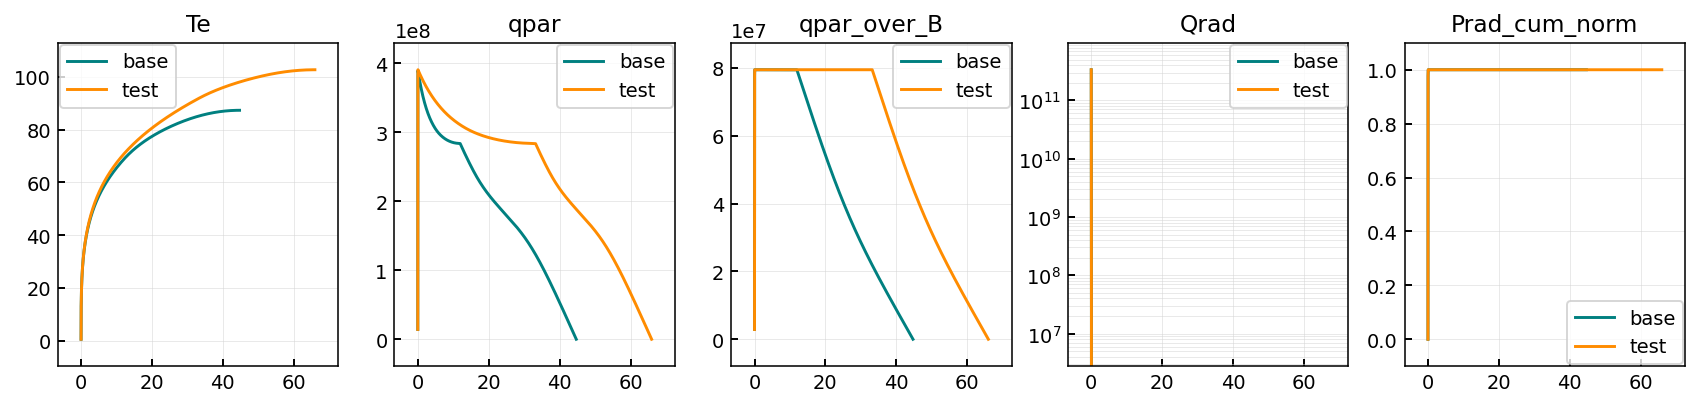

In [142]:
toplot = dict(
    base = comps_inner["Lc"]["Curve 1"][1].dls,
    test = comps_inner["Lc"]["Curve 1"][1.5].dls
)
params = ["Te", "qpar", "qpar_over_B", "Qrad", "Prad_cum_norm"]

xlims_zoom = (0, 35)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

# Front width evolution

## Front width: base

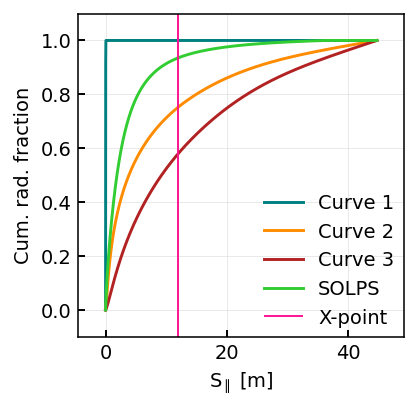

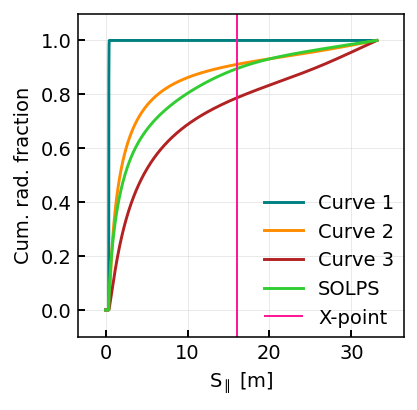

In [196]:
for side in ["inner", "outer"]: 

    fig, ax = plt.subplots(figsize = (3,3))

    for curve in curves[f"set_{side}"].keys():
        i = 1
        # for fR in store_profiles["fR"].keys():
        comp = comps[side]["Lc"][curve][i]
        dls = comp.dls
        ax.plot(dls["Spar"], dls["Prad_cum_norm"], label = curve)
        
    x = dls[dls["Xpoint"]==1].squeeze()
    ylim = ax.get_ylim()
    ax.vlines(x["Spar"], *ylim, lw = 1, color = "deeppink", label = "X-point")
    ax.set_ylim(ylim)
    ax.legend(frameon = False)
    ax.set_xlabel("$S_{\parallel}$ [m]")
    ax.set_ylabel("Cum. rad. fraction")

    # fig.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_frontwidths_{side}_lower.pdf", format = "pdf")

## Front width: base for synopsis

In [137]:
comps_outer

{'fR': {'Thin': {2: <DLS.postprocess.compare_SOLPS_DLS at 0x222175e3620>,
   4: <DLS.postprocess.compare_SOLPS_DLS at 0x222187eb650>},
  'Argon\n(coronal)': {2: <DLS.postprocess.compare_SOLPS_DLS at 0x222175e1a60>,
   4: <DLS.postprocess.compare_SOLPS_DLS at 0x2220a991ee0>},
  'Argon': {2: <DLS.postprocess.compare_SOLPS_DLS at 0x2220a8dc830>,
   4: <DLS.postprocess.compare_SOLPS_DLS at 0x2220a8a4830>},
  'Neon': {2: <DLS.postprocess.compare_SOLPS_DLS at 0x2220ad2cce0>,
   4: <DLS.postprocess.compare_SOLPS_DLS at 0x2220ad1cce0>},
  'SOLPS': {2: <DLS.postprocess.compare_SOLPS_DLS at 0x2220a926c00>,
   4: <DLS.postprocess.compare_SOLPS_DLS at 0x22209d44830>}},
 'Lc': {'Thin': {1: <DLS.postprocess.compare_SOLPS_DLS at 0x222012120c0>,
   2: <DLS.postprocess.compare_SOLPS_DLS at 0x222011deb70>},
  'Argon\n(coronal)': {1: <DLS.postprocess.compare_SOLPS_DLS at 0x222011dd0a0>,
   2: <DLS.postprocess.compare_SOLPS_DLS at 0x22209e16f60>},
  'Argon': {1: <DLS.postprocess.compare_SOLPS_DLS at 0x222

In [139]:
dls

,Qrad,Spar,Spol,Te,qpar,Btot,Bpol,Ne,cz,Pe,Xpoint,qradial,Qrad_per_area,Qrad_per_area_cum,Qrad_per_area_cum_norm,Qrad_cum,Qrad_cum_norm,qpar_over_B
0,1.044786e+11,0.000000,0.000000,0.500000,1.525492e+07,1.812058,0.940354,1.101878e+22,0.05,882.701832,NaN,1.000000e+00,2.061096e+10,0.000000e+00,0.000000,0.000000e+00,0.000000,8.418559e+06
1,2.588031e+10,0.000397,0.000205,2.018496,3.007186e+07,1.812068,0.940242,2.729454e+21,0.05,882.701832,NaN,1.000000e+00,1.653010e+10,7.367286e+06,0.087297,1.426991e+07,0.157575,1.659532e+07
2,2.005144e+10,0.000793,0.000410,2.605264,3.902162e+07,1.812079,0.940131,2.114715e+21,0.05,882.701832,NaN,1.000000e+00,1.132668e+10,1.289294e+07,0.152772,1.929786e+07,0.213096,2.153417e+07
3,1.715189e+10,0.001190,0.000614,3.045688,4.635751e+07,1.812090,0.940019,1.808915e+21,0.05,882.701832,NaN,1.000000e+00,9.568405e+09,1.703769e+07,0.201884,2.337032e+07,0.258066,2.558235e+07
4,1.530930e+10,0.001587,0.000819,3.412260,5.277944e+07,1.812100,0.939908,1.614587e+21,0.05,882.701832,NaN,1.000000e+00,8.504112e+09,2.062254e+07,0.244361,2.692366e+07,0.297304,2.912611e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000000e+00,33.077305,8.324766,93.804810,1.917248e+05,2.077364,1.473273,5.873251e+19,0.05,882.701832,NaN,1.398610e+07,6.396219e-01,8.439339e+07,0.999997,9.055943e+07,1.000000,9.229232e+04
9996,0.000000e+00,33.085657,8.330689,93.804815,7.491055e+04,2.077359,1.473273,5.873250e+19,0.05,882.701832,NaN,1.398610e+07,6.996589e-01,8.439339e+07,0.999997,9.055943e+07,1.000000,3.606047e+04
9997,0.000000e+00,33.094009,8.336613,93.804815,-4.190336e+04,2.077355,1.473271,5.873250e+19,0.05,882.701832,NaN,1.398610e+07,6.822955e-01,8.439339e+07,0.999997,9.055943e+07,1.000000,-2.017150e+04
9998,0.000000e+00,33.102361,8.342536,93.804812,-1.587171e+05,2.077351,1.473268,5.873250e+19,0.05,882.701832,NaN,1.398610e+07,5.874991e-01,8.439339e+07,0.999997,9.055943e+07,1.000000,-7.640359e+04


In [ ]:
fig, axes = plt.subplots(2,2, figsize = (6.5,6.5), dpi = 300)

for side_id, side in enumerate(["outer", "inner"]):

    for name, function in curves[f"set_{side}"].items():
        Lz = [function(temp) for temp in T]
        Lz = Lz/np.max(Lz)
        axes[side_id, 0].plot(T, Lz, lw = 1.5)

    axes[side_id, 0].xaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
    axes[side_id, 0].set_xlabel(r"$T_e$ [eV]")
    axes[side_id, 0].set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
    axes[side_id, 0].set_xlim(-10,200)

    for curve in curves[f"set_{side}"].keys():
        i = 1

        dls = FrontLocation(store_choices[side]["Lc"][curve][i], 0).data
        axes[side_id, 1].plot(dls["Spar"], dls["Qrad_cum_norm"], label = curve if side_id == 0 else None)
        
    x = dls[dls["Xpoint"]==1].squeeze()
    ylim = axes[side_id, 1].get_ylim()
    axes[side_id, 1].vlines(x["Spar"], *ylim, lw = 1, ls = "--", color = "deeppink", label = "X-point location" if side_id == 0 else None)
    axes[side_id, 1].set_ylim(ylim)

    axes[side_id, 1].set_xlabel(r"$S_{\parallel}$ [m]")
    axes[side_id, 1].set_ylabel("Cumulative radiation fraction")
    
axes[0, 0].text(0.85,0.15,s = "a)", fontdict=dict(fontsize="xx-large"), transform = axes[0, 0].transAxes)
axes[0, 1].text(0.85,0.15,s = "b)", fontdict=dict(fontsize="xx-large"), transform = axes[0, 1].transAxes)
axes[1, 0].text(0.85,0.15,s = "c)", fontdict=dict(fontsize="xx-large"), transform = axes[1, 0].transAxes)
axes[1, 1].text(0.85,0.15,s = "d)", fontdict=dict(fontsize="xx-large"), transform = axes[1, 1].transAxes)
    
fig.subplots_adjust(wspace = 0.3, hspace = 0.4)
fig.text(0.42, 0.9, "Outer divertor", fontsize = "large")
fig.text(0.42, 0.45, "Inner divertor", fontsize = "large")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,0.03), ncol = 3, frameon = False)
fig.savefig(rf"C:\Users\Mike\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_curves_frontwidths.pdf", format = "pdf")

## Front width: fR

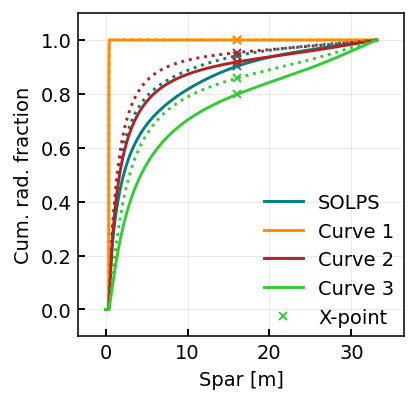

In [ ]:
colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(figsize = (3,3))

for i, curve in enumerate(curves["set"].keys()):

    # for fR in store_profiles["fR"].keys():
    comp = comps_outer["fR"][curve][2]
    dls = comp.dls
    ax.plot(dls["Spar"], dls["Prad_cum_norm"], color = colors[i], label = curve)
    dlsx = dls[dls["Xpoint"]==1].squeeze()
    ax.plot(dlsx["Spar"], dlsx["Prad_cum_norm"], color = colors[i], marker = "x", ms = 4, lw = 0, label = "X-point" if i == len(curves["set"])-1 else "")
    
    comp = comps_outer["fR"][curve][4]
    dls = comp.dls
    ax.plot(dls["Spar"], dls["Prad_cum_norm"], color = colors[i], ls = ":")
    dlsx = dls[dls["Xpoint"]==1].squeeze()
    ax.plot(dlsx["Spar"], dlsx["Prad_cum_norm"], color = colors[i], marker = "x", ms = 4, lw = 0)
    

ax.legend(frameon = False)
ax.set_xlabel("Spar [m]")
ax.set_ylabel("Cum. rad. fraction")
fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_fR_frontwidths.pdf", format = "pdf")


## Front width: Lc

Text(0.5, 1.0, 'Front widths before (solid) and after (dotted)')

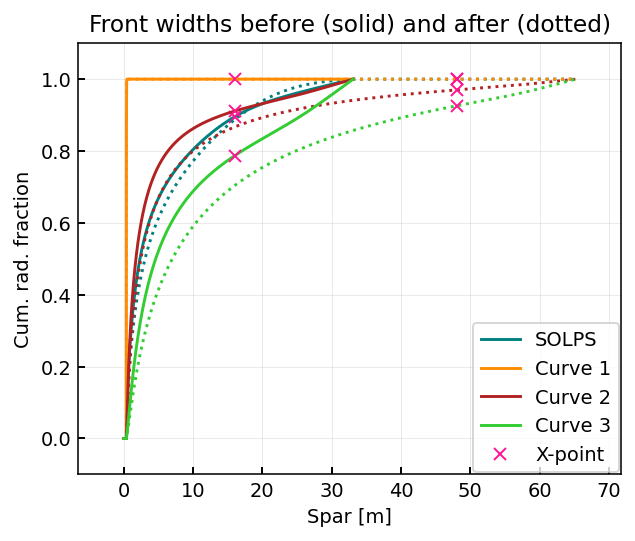

In [ ]:
colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots()

for i, curve in enumerate(curves["set"].keys()):

    # for fR in store_profiles["fR"].keys():
    comp = comps_outer["Lc"][curve][1]
    dls = comp.dls
    ax.plot(dls["Spar"], dls["Prad_cum_norm"], color = colors[i], label = curve)
    dlsx = dls[dls["Xpoint"]==1].squeeze()
    ax.plot(dlsx["Spar"], dlsx["Prad_cum_norm"], color = "deeppink", marker = "x", ms = 6, lw = 0, label = "X-point" if i == len(curves["set"])-1 else "")
    
    comp = comps_outer["Lc"][curve][2]
    dls = comp.dls
    ax.plot(dls["Spar"], dls["Prad_cum_norm"], color = colors[i], ls = ":")
    dlsx = dls[dls["Xpoint"]==1].squeeze()
    ax.plot(dlsx["Spar"], dlsx["Prad_cum_norm"], color = "deeppink", marker = "x", ms = 6, lw = 0)
    
# x = dls[dls["Xpoint"]==1].squeeze()
# ylim = ax.get_ylim()
# ax.vlines(x["Spar"], *ylim, lw = 1, color = "deeppink", label = "X-point")
# ax.set_ylim(ylim)
ax.legend()
ax.set_xlabel("Spar [m]")
ax.set_ylabel("Cum. rad. fraction")
ax.set_title("Front widths before (solid) and after (dotted)")


### wide_2 deep dive

Text(0.5, 1.04, 'wide_2')

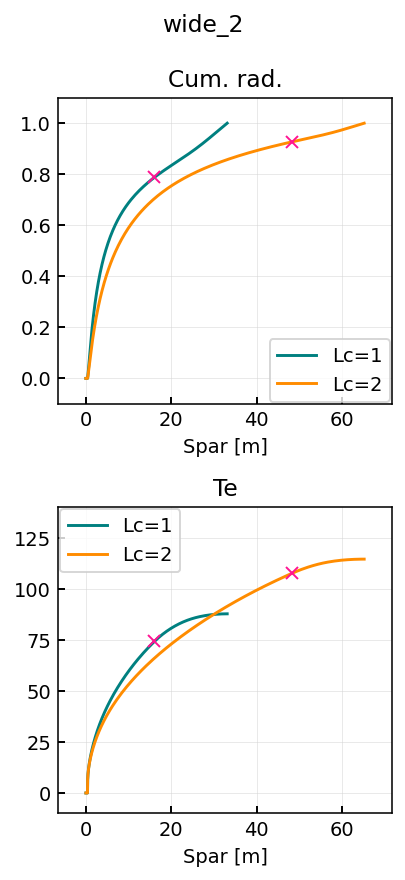

In [ ]:
colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

curve = "wide_2"

fig, axes = plt.subplots(2,1, figsize = (3,6))

dfs = {1 : comps_outer["Lc"][curve][1].dls, 2 : comps_outer["Lc"][curve][2].dls}
xpoint_style = dict(lw = 0, marker = "x", ms = 6, c = "deeppink")

for Lc in dfs.keys():
    df = dfs[Lc]
    dfx = df[df["Xpoint"]==1].squeeze()
    axes[0].plot(df["Spar"], df["Prad_cum_norm"], label = f"Lc={Lc}")
    axes[0].plot(dfx["Spar"], dfx["Prad_cum_norm"], **xpoint_style)
    axes[1].plot(df["Spar"], df["Te"], label = f"Lc={Lc}")
    axes[1].plot(dfx["Spar"], dfx["Te"], **xpoint_style)
    
for ax in axes:
    ax.set_xlabel("Spar [m]")
    ax.legend()
    
axes[0].set_title("Cum. rad.")
axes[1].set_title("Te")
axes[1].set_ylim(-10, 140)
fig.tight_layout()
fig.suptitle(curve, y = 1.04)
# dls = comp.dls
# comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)



# Sensitivity
-  Removed for clarity, see previous versions. 